 # Importing Files

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime 

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import chi2
from scipy.stats import chi2_contingency
from sklearn.feature_selection import VarianceThreshold

import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence
from pygam import LinearGAM, s, l
from dmba import stepwise_selection
from dmba import AIC_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile

# Import Files

In [41]:
# parsing date column
df= pd.read_csv('test_volume_data.csv',parse_dates=['date'])
df["date"] = pd.to_datetime(df["date"])
df.head()

,company_id,company_type,date,avg_pesq_score,quality_too_poor,number_busy,temporarily_unable_test,outage_sec,number_test_types,numbers_tested,followup_tests,min_commit,has_min_commit,volume_tests,is_testing
0,1,Conference,2018-01-01,4.183942,1,86,0,6680.24,2,2562,0,100000.0,1,4590,1
1,2,Enterprise,2018-01-01,3.692000,4,246,0,2208.22,2,2410,100,400000.0,1,35405,1
2,4,Enterprise,2018-01-01,0.000000,0,1,0,0.00,1,207,0,1500.0,1,302,1
3,6,Conference,2018-01-01,3.971564,0,0,0,695.99,2,62,0,5715.0,1,167,1
4,10,Enterprise,2018-01-01,3.371562,0,0,0,0.00,1,13,0,NaN,0,672,1


In [5]:
df.info()
# single categorical column : company type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108760 entries, 0 to 108759
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   company_id               108760 non-null  int64         
 1   company_type             108760 non-null  object        
 2   date                     108760 non-null  datetime64[ns]
 3   avg_pesq_score           108760 non-null  float64       
 4   quality_too_poor         108760 non-null  int64         
 5   number_busy              108760 non-null  int64         
 6   temporarily_unable_test  108760 non-null  int64         
 7   outage_sec               108760 non-null  float64       
 8   number_test_types        108760 non-null  int64         
 9   numbers_tested           108760 non-null  int64         
 10  followup_tests           108760 non-null  int64         
 11  min_commit               53438 non-null   float64       
 12  has_min_commit  

# Null column Exploration

In [4]:
#checking nan values
for col in df.columns:
    if df[col].isnull().any():
        print(col, df[col].isnull().sum())

min_commit 55322


    # checking null first if they are missing on purpose or by random ?
    # single column is missing need to check its relation with other columns

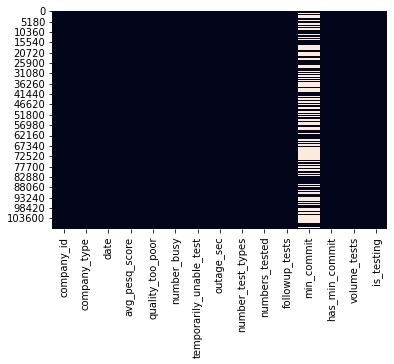

In [11]:
sns.heatmap(df.isnull(), cbar=False);

In [297]:
df['volume_tests'][(df['min_commit'].isnull())  & (df['is_testing'] ==0) & (df['volume_tests'] ==0 ) ].value_counts()
# min_commit is null is_testing is zero and volume of test are also null total rows are 29K

0    29511
Name: volume_tests, dtype: int64

In [298]:
df[(df['volume_tests'] !=0)  & (df['is_testing'] ==0)].value_counts()
# there are no test going on where is testing is zero 

Series([], dtype: int64)

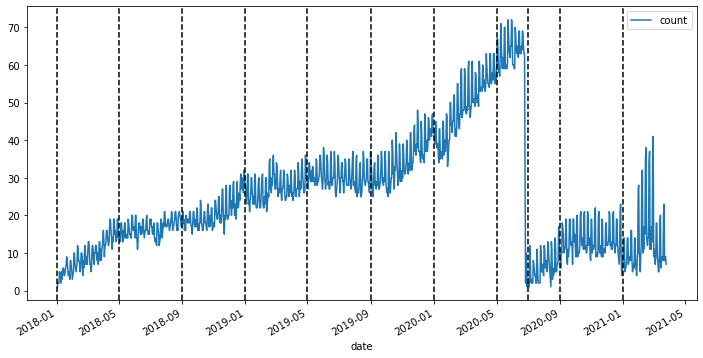

In [300]:
null_time=df[(df['min_commit'].isnull())  & (df['is_testing'] ==0) & (df['volume_tests'] ==0 )].groupby('date').size().reset_index(name='count').sort_values('count')
ax = null_time.plot(x='date', y='count', figsize=(12,6))
xcoords = ['2018-01-01', '2018-05-01','2018-09-01', '2019-01-01', '2019-05-01', '2019-09-01',
          '2020-01-01','2020-05-01','2020-07-01','2020-09-01','2021-01-01']
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')
#null with no testing steadily increasing and dropped just few days before 2020-07-01
# no conclusion as we yet to see data trend itself

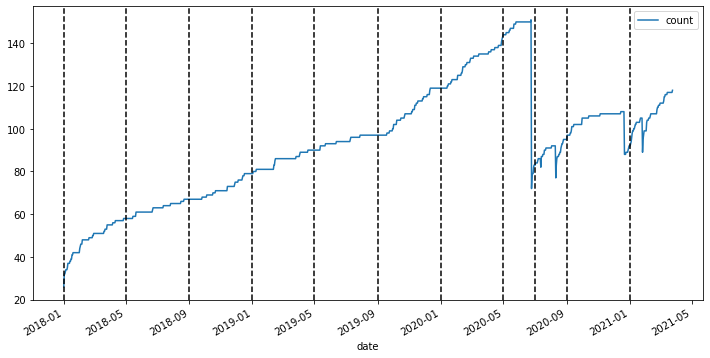

In [302]:
# there is a overall drop in testing itself around need to dig into this more
volume_test_size=df.groupby('date')['volume_tests'].size().reset_index(name='count').sort_values('count')
ax = volume_test_size.plot(x='date', y='count', figsize=(12,6))
xcoords = ['2018-01-01', '2018-05-01','2018-09-01', '2019-01-01', '2019-05-01', '2019-09-01',
          '2020-01-01','2020-05-01','2020-07-01','2020-09-01','2021-01-01']
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')

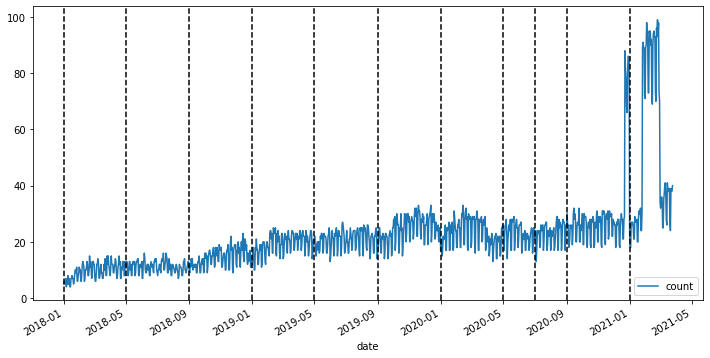

In [303]:
# lets first complete the null column exploration
null_time=df[(df['min_commit'].isnull())  & (df['is_testing'] ==1)].groupby('date').size().reset_index(name='count').sort_values('count')
ax = null_time.plot(x='date', y='count', figsize=(12,6))
xcoords = ['2018-01-01', '2018-05-01','2018-09-01', '2019-01-01', '2019-05-01', '2019-09-01',
          '2020-01-01','2020-05-01','2020-07-01','2020-09-01','2021-01-01']
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')
# Null values in min_commit column are present but still companies are doing testing 
# null values are more in 2021 there seems to be more null values is this systematic issue?

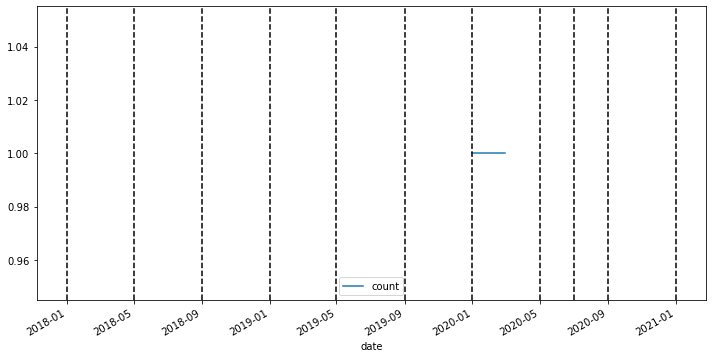

In [304]:
# only for a short period of time we have min_commit=zero
null_time=df[(df['min_commit']==0)].groupby('date').size().reset_index(name='count').sort_values('count')
ax = null_time.plot(x='date', y='count', figsize=(12,6))
xcoords = ['2018-01-01', '2018-05-01','2018-09-01', '2019-01-01', '2019-05-01', '2019-09-01',
          '2020-01-01','2020-05-01','2020-07-01','2020-09-01','2021-01-01']
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')

In [305]:
# average volume of test where we have null values and avg value of test where we have not null values and where we have zero
null_time=df[(df['min_commit'].isnull())].groupby('date')['volume_tests'].mean().reset_index(name='average').sort_values('average')

nonull_time=df[(df['min_commit'].notnull())].groupby('date')['volume_tests'].mean().reset_index(name='average').sort_values('average')

zero_time=df[(df['min_commit']==0)].groupby('date')['volume_tests'].mean().reset_index(name='average').sort_values('average')

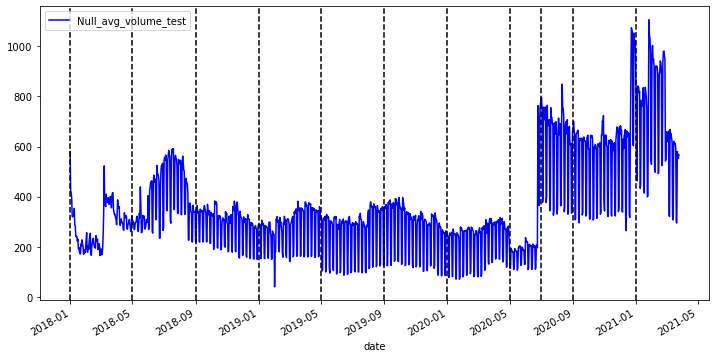

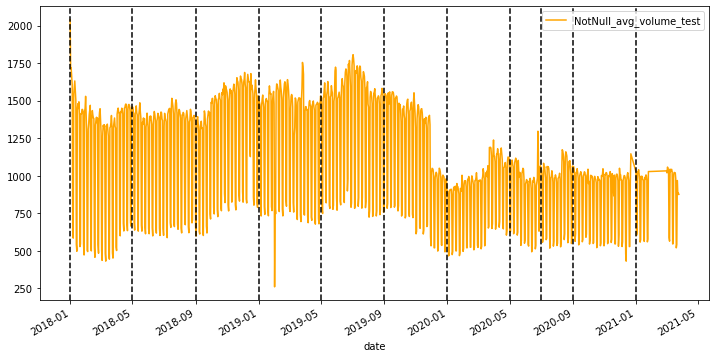

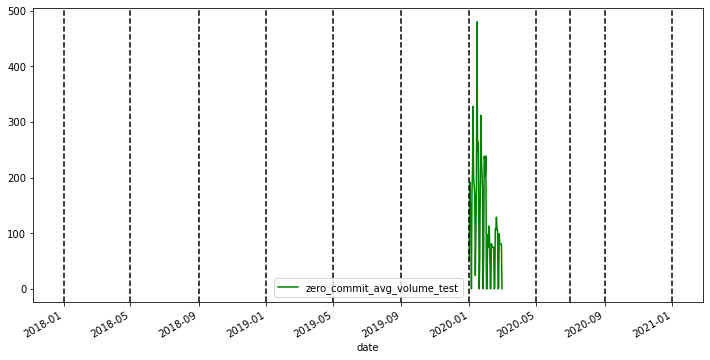

In [306]:
# lets first complete the null column exploration
ax1 = null_time.plot(x='date', y='average',color='blue',label='Null_avg_volume_test',figsize=(12,6))
xcoords = ['2018-01-01', '2018-05-01','2018-09-01', '2019-01-01', '2019-05-01', '2019-09-01',
          '2020-01-01','2020-05-01','2020-07-01','2020-09-01','2021-01-01']
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')
ax2 = nonull_time.plot(x='date', y='average',color='orange',label='NotNull_avg_volume_test',figsize=(12,6))

xcoords = ['2018-01-01', '2018-05-01','2018-09-01', '2019-01-01', '2019-05-01', '2019-09-01',
          '2020-01-01','2020-05-01','2020-07-01','2020-09-01','2021-01-01']
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')

ax3 = zero_time.plot(x='date', y='average',color='green',label='zero_commit_avg_volume_test',figsize=(12,6))

xcoords = ['2018-01-01', '2018-05-01','2018-09-01', '2019-01-01', '2019-05-01', '2019-09-01',
          '2020-01-01','2020-05-01','2020-07-01','2020-09-01','2021-01-01']
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')
# average test volume is different where we have null values and where we dont have and we have a systematic date related issue
# not sure if its business realted or data error , where we have min_commit=zero 

In [307]:
# for now we can assume min_commit has some systematic issue but it might be safe to make it zero for null values 
# as we do have some zero values present for this column 
# we can go bit more deep and check company type and other columns it might be to exhaustive


In [308]:
#print(df['company_type'].value_counts())
#print(df['company_type'].value_counts(normalize=True) * 100)

analysis = df['company_type']
analysis = pd.concat([analysis.value_counts(),analysis.value_counts(normalize=True).mul(100)],axis=1,keys=('counts','percentage'))
print (analysis)
# we have more enterprise companies

            counts  percentage
Enterprise   94178   86.592497
Conference    8894    8.177639
Carrier       5688    5.229864


In [309]:
df[(df['min_commit']==0)].groupby('company_type')['is_testing'].value_counts()
#only enterprise has min_commit=0 

company_type  is_testing
Enterprise    1             51
              0              9
Name: is_testing, dtype: int64

In [310]:
df[(df['min_commit'].isnull())].groupby('company_type')['is_testing'].value_counts()
# there seems to be little to no connection between missing values and company type

company_type  is_testing
Carrier       1              2995
              0               788
Conference    1              2502
              0              1557
Enterprise    0             27166
              1             20314
Name: is_testing, dtype: int64

In [330]:
# or we can replace max occurence of min_commit by company id 
# we could have chosen min_commit value just before null came but or after 
# best scenario can be determined only by business knowledge , here i guess this idea will be okay
#sam=df.groupby("company_id")["min_commit"].value_counts().to_frame()
#sam.rename(columns={'min_commit':'count'},inplace=True)
#sam2=sam.groupby(['company_id'],sort=False,group_keys=False).apply(lambda x: x.sort_values('count',ascending=False)[:1])
#sam2.reset_index(inplace=True)
#sam2.head()

,company_id,min_commit,count
0,1,58333.0,991
1,2,400000.0,1137
2,3,10000.0,438
3,4,10000.0,591
4,6,5715.0,1137


In [331]:
#df=pd.merge(df,sam2, on=['company_id'],how='left')


In [332]:
#df['min_commit_x'].fillna(df['min_commit_y'],inplace=True)
#df.head()

,company_id,company_type,date,avg_pesq_score,quality_too_poor,number_busy,temporarily_unable_test,outage_sec,number_test_types,numbers_tested,followup_tests,min_commit_x,has_min_commit,volume_tests,is_testing,min_commit_y,count
0,1,Conference,2018-01-01,4.183942,1,86,0,6680.24,2,2562,0,100000.0,1,4590,1,58333.0,991.0
1,2,Enterprise,2018-01-01,3.692000,4,246,0,2208.22,2,2410,100,400000.0,1,35405,1,400000.0,1137.0
2,4,Enterprise,2018-01-01,0.000000,0,1,0,0.00,1,207,0,1500.0,1,302,1,10000.0,591.0
3,6,Conference,2018-01-01,3.971564,0,0,0,695.99,2,62,0,5715.0,1,167,1,5715.0,1137.0
4,10,Enterprise,2018-01-01,3.371562,0,0,0,0.00,1,13,0,2667.0,0,672,1,2667.0,1078.0


In [334]:
#for col in df.columns:
#    if df[col].isnull().any():
#        print(col, df[col].isnull().sum())

min_commit_x 34891
min_commit_y 34891
count 34891


In [341]:
#df[df['min_commit_x'].isnull()].groupby("company_id")["company_id"].value_counts()

company_id  company_id
9           9             1177
13          13            1141
17          17            1180
28          28            1173
44          44             243
                          ... 
431         431             47
444         444             64
447         447             60
450         450             31
455         455             17
Name: company_id, Length: 95, dtype: int64

In [344]:
#df[(df['company_id']==9)].groupby('min_commit_x')['min_commit_x'].value_counts()
# rest of the company never had any min_commit we can keep them zero if we want as number is around 34k which is not small

Series([], Name: min_commit_x, dtype: int64)

In [345]:
#df.drop(['min_commit_y','count'],axis=1, inplace=True)

In [346]:
#df.rename(columns = {"min_commit_x": "min_commit"}, inplace = True)
#df.head()

,company_id,company_type,date,avg_pesq_score,quality_too_poor,number_busy,temporarily_unable_test,outage_sec,number_test_types,numbers_tested,followup_tests,min_commit,has_min_commit,volume_tests,is_testing
0,1,Conference,2018-01-01,4.183942,1,86,0,6680.24,2,2562,0,100000.0,1,4590,1
1,2,Enterprise,2018-01-01,3.692000,4,246,0,2208.22,2,2410,100,400000.0,1,35405,1
2,4,Enterprise,2018-01-01,0.000000,0,1,0,0.00,1,207,0,1500.0,1,302,1
3,6,Conference,2018-01-01,3.971564,0,0,0,695.99,2,62,0,5715.0,1,167,1
4,10,Enterprise,2018-01-01,3.371562,0,0,0,0.00,1,13,0,2667.0,0,672,1


In [42]:
# all of the above i messed up as i did'nt saw the column has_min_commit
# all values are null where we have has_min_commit ==zero
df['min_commit'].fillna(0,inplace=True)
for col in df.columns:
    if df[col].isnull().any():
        print(col, df[col].isnull().sum())
# done nothing to impute now

In [ ]:
# we check other type of missing values where all values are zero

# Univariate analysis ( Outliers , Skewness , others )

In [4]:
# before doing anything further just create holdout dataset
DF_test= df[df['date'] > '2021-02-28' ]
df= df[df['date'] <= '2021-02-28' ]

In [5]:
df.tail()

,company_id,company_type,date,avg_pesq_score,quality_too_poor,number_busy,temporarily_unable_test,outage_sec,number_test_types,numbers_tested,followup_tests,min_commit,has_min_commit,volume_tests,is_testing
105876,418,Enterprise,2021-02-28,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0
105877,420,Enterprise,2021-02-28,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0
105878,444,Carrier,2021-02-28,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0
105879,447,Enterprise,2021-02-28,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0
105880,450,Enterprise,2021-02-28,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0


In [13]:
# check variance 
analysis=df[['avg_pesq_score','quality_too_poor','number_busy','temporarily_unable_test',
             'outage_sec','numbers_tested','followup_tests','min_commit','volume_tests']]
sel = VarianceThreshold(threshold=0.01)
sel.fit(analysis) 
# if we sum over get_support, we get the number of features that are not constant
sum(sel.get_support())

9

In [10]:
numeric_data = df.select_dtypes(include=[np.number]).copy()
categorical_data = df.select_dtypes(exclude=[np.number]).copy()

In [503]:
numeric_data

,company_id,avg_pesq_score,quality_too_poor,number_busy,temporarily_unable_test,outage_sec,number_test_types,numbers_tested,followup_tests,min_commit,has_min_commit,volume_tests,is_testing
0,1,4.183942,1,86,0,6680.24,2,2562,0,100000.0,1,4590,1
1,2,3.692000,4,246,0,2208.22,2,2410,100,400000.0,1,35405,1
2,4,0.000000,0,1,0,0.00,1,207,0,1500.0,1,302,1
3,6,3.971564,0,0,0,695.99,2,62,0,5715.0,1,167,1
4,10,3.371562,0,0,0,0.00,1,13,0,0.0,0,672,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
105876,418,0.000000,0,0,0,0.00,0,0,0,0.0,0,0,0
105877,420,0.000000,0,0,0,0.00,0,0,0,0.0,0,0,0
105878,444,0.000000,0,0,0,0.00,0,0,0,0.0,0,0,0
105879,447,0.000000,0,0,0,0.00,0,0,0,0.0,0,0,0


In [410]:
analysis = df['company_id']
analysis = pd.concat([analysis.value_counts(),analysis.value_counts(normalize=True).mul(100)],axis=1,keys=('counts','percentage'))
print (analysis.sort_values('counts'))
# company entries are not even 
# still we check uniformaty with graph of one company

     counts  percentage
418       5    0.004722
450       6    0.005667
387      19    0.017945
388      19    0.017945
300      28    0.026445
..      ...         ...
10     1155    1.090847
6      1155    1.090847
118    1155    1.090847
49     1155    1.090847
1      1155    1.090847

[176 rows x 2 columns]


In [411]:
analysis=df[(df['company_id']==1)].groupby('date').size().reset_index(name='count').sort_values('count')


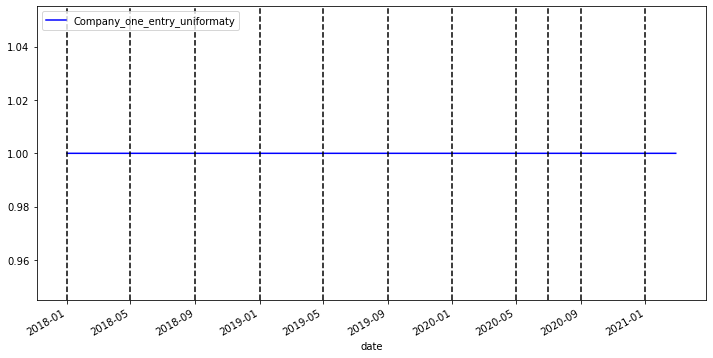

In [412]:

ax1 = analysis.plot(x='date', y='count',color='blue',label='Company_one_entry_uniformaty',figsize=(12,6))
xcoords = ['2018-01-01', '2018-05-01','2018-09-01', '2019-01-01', '2019-05-01', '2019-09-01',
          '2020-01-01','2020-05-01','2020-07-01','2020-09-01','2021-01-01']
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')

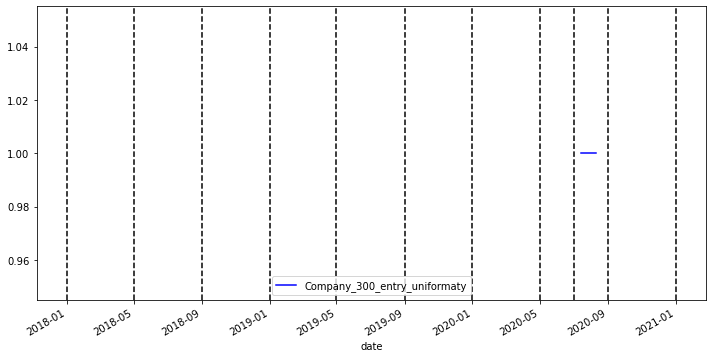

In [413]:
analysis=df[(df['company_id']==300)].groupby('date').size().reset_index(name='count').sort_values('count')

ax1 = analysis.plot(x='date', y='count',color='blue',label='Company_300_entry_uniformaty',figsize=(12,6))
xcoords = ['2018-01-01', '2018-05-01','2018-09-01', '2019-01-01', '2019-05-01', '2019-09-01',
          '2020-01-01','2020-05-01','2020-07-01','2020-09-01','2021-01-01']
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')
# some companies entries are uniform and others are not , they might have left the organization

In [414]:
(df == 0).astype(int).sum(axis=1)
# there are some rows where everythin is zero 
# not sure if this is a data issue or this is just a entry
# chances are its a data issue if there were entry for each company each day inrespective of volume test we would have
# same count for companies or uniform counts
# but we will let this be wont delete the data 


0          2
1          1
2          5
3          4
4          7
          ..
105876    12
105877    12
105878    12
105879    12
105880    12
Length: 105881, dtype: int64

In [415]:
(df == 0).astype(int).sum(axis=1).value_counts().sort_values()
# total 20k values are where all numerical columns are zero
# not sure if this is part of valid entry or entry issue and we should remove it 
# we wont be removing it though

0       833
1      2486
8      3153
2      5534
7      6238
9      6246
10     6359
11     8580
6      9547
3     10139
5     11622
4     14475
12    20669
dtype: int64

In [519]:
numeric_data.drop(['company_id'],axis=1,inplace=True)
numeric_data.describe()

# most of the avg_pesq_score are also zero median itself is zero not sure if data issue or genuine 
# we can check for company id where we have other score also available and some places its zero we can replace
# but we wont as we are not aware of the business rules as this score can be time dependent score or due a reason it was kept zero
# can be float

# quality to poor also has some issue an extreme value 627 not sure if thats genuine , its number of test rated poor
# it should not be greater than number of test conducted that day
# should be int

# number of test returned busy again has a very extereme values
# should be int , this column mostly looks vary dispursed as its std is also 66


# temporarily_unable_test same as above number bussy , but less std compared to that

# should be float and we might need to convert to mins or do some standardization

# different test type sounds categorical need to explore 
# got some data from spearline site
# Connection Test
#Voice Quality Test
#Latency Test
#Standard Conference Test

# numbers tested .. is number of unique testing this feature might cause data leakage but not sure due to business reasons 
# behind that , higher std 

# folloup test hi std 
# min commit and has min commit as related ( i missed it up and wasted lot of time )
# min_commit has very high std

# volume_tests i am assuming is the target variable 
# is testing might be a feature leakage 

,avg_pesq_score,quality_too_poor,number_busy,temporarily_unable_test,outage_sec,number_test_types,numbers_tested,followup_tests,min_commit,has_min_commit,volume_tests,is_testing
count,105881.000000,105881.000000,105881.000000,105881.000000,105881.000000,105881.000000,105881.000000,105881.000000,105881.000000,105881.00000,105881.000000,105881.000000
mean,1.685454,1.279380,12.573219,1.251263,558.766729,0.921648,67.953193,2.854299,7944.551421,0.48767,707.579641,0.639709
std,1.908950,10.452038,66.028674,16.123530,1828.356203,1.093184,329.480761,28.863829,42143.533507,0.49985,4135.667318,0.480087
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,24.000000,1.000000,2.000000,0.000000,0.000000,0.00000,26.000000,1.000000
75%,3.822915,0.000000,3.000000,0.000000,192.000000,2.000000,35.000000,0.000000,2000.000000,1.00000,196.000000,1.000000
max,4.500000,627.000000,4492.000000,1258.000000,29111.660000,6.000000,4927.000000,3844.000000,400000.000000,1.00000,57105.000000,1.000000


In [400]:
#df.drop(df[df['min_commit'] >= 400000].index, inplace = True)
#numeric_data = df.select_dtypes(include=[np.number])

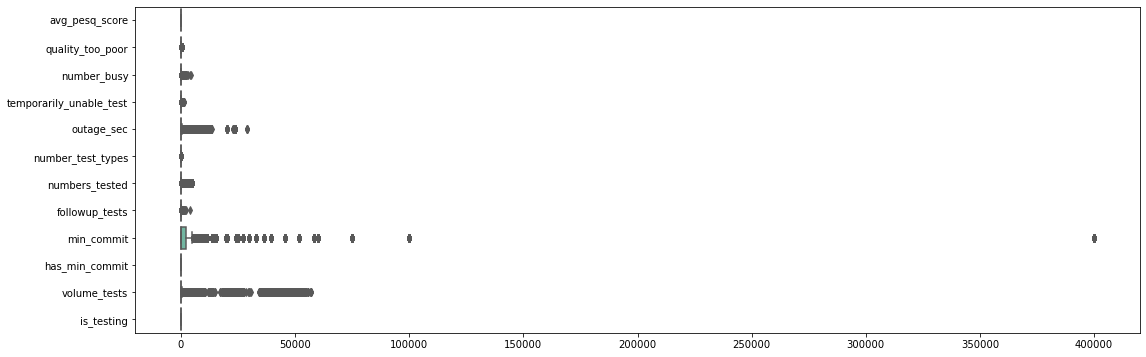

In [505]:
# box plots for all
plt.figure(figsize=(18,6))
ax = sns.boxplot(data=numeric_data, orient="h", palette="Set2")
# all features look they are right skewed and due to loads of outliers in min_commit we are having problem in graphs

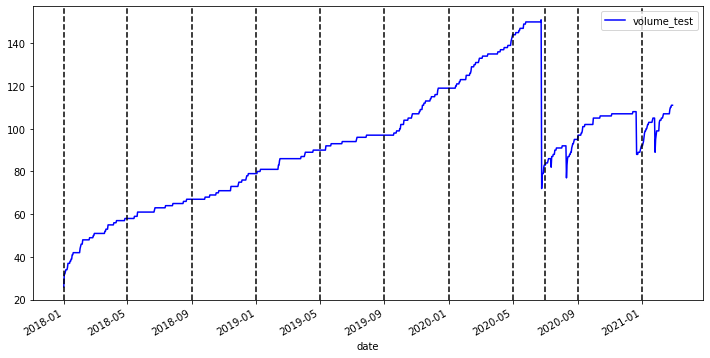

In [418]:
null_time=df.groupby('date')['volume_tests'].count().reset_index(name='count').sort_values('count')
ax1 = null_time.plot(x='date', y='count',color='blue',label='volume_test',figsize=(12,6))
xcoords = ['2018-01-01', '2018-05-01','2018-09-01', '2019-01-01', '2019-05-01', '2019-09-01',
          '2020-01-01','2020-05-01','2020-07-01','2020-09-01','2021-01-01']
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')
    # entries of volume test drops there is a chnage point due to covid maybe assumption

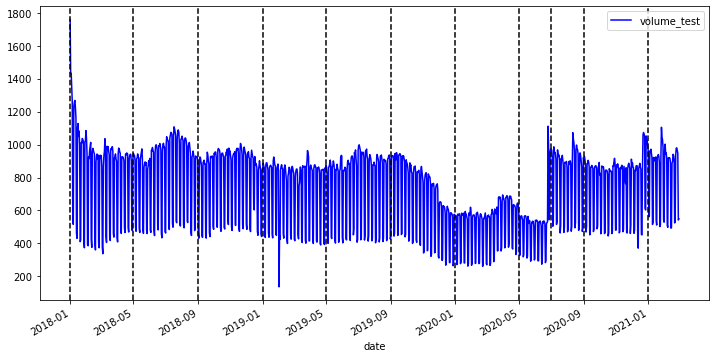

In [419]:
null_time=df.groupby('date')['volume_tests'].mean().reset_index(name='mean').sort_values('mean')
ax1 = null_time.plot(x='date', y='mean',color='blue',label='volume_test',figsize=(12,6))
xcoords = ['2018-01-01', '2018-05-01','2018-09-01', '2019-01-01', '2019-05-01', '2019-09-01',
          '2020-01-01','2020-05-01','2020-07-01','2020-09-01','2021-01-01']
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')
    # there is a opposite bounce back in avg volume test counts by companies 
    # we do see some change points in 2019 dec -2020-july
# we might need to consider different models for before and after changepoint 
# it might be bit complicated we can try later , or we can try single model also


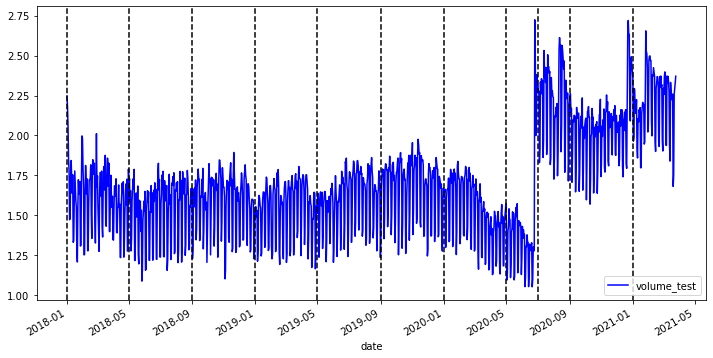

In [44]:
null_time=df.groupby('date')['avg_pesq_score'].mean().reset_index(name='mean').sort_values('mean')
ax1 = null_time.plot(x='date', y='mean',color='blue',label='volume_test',figsize=(12,6))
xcoords = ['2018-01-01', '2018-05-01','2018-09-01', '2019-01-01', '2019-05-01', '2019-09-01',
          '2020-01-01','2020-05-01','2020-07-01','2020-09-01','2021-01-01']
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')

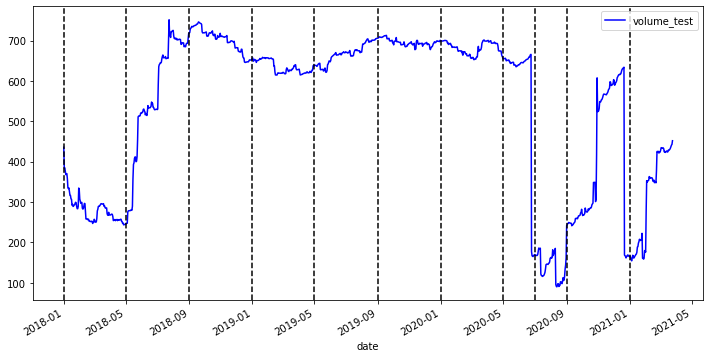

In [48]:
null_time=df.groupby('date')['outage_sec'].mean().reset_index(name='mean').sort_values('mean')
ax1 = null_time.plot(x='date', y='mean',color='blue',label='volume_test',figsize=(12,6))
xcoords = ['2018-01-01', '2018-05-01','2018-09-01', '2019-01-01', '2019-05-01', '2019-09-01',
          '2020-01-01','2020-05-01','2020-07-01','2020-09-01','2021-01-01']
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')

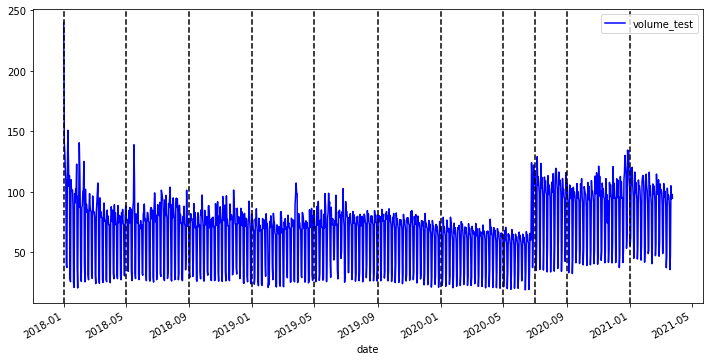

In [49]:
null_time=df.groupby('date')['numbers_tested'].mean().reset_index(name='mean').sort_values('mean')
ax1 = null_time.plot(x='date', y='mean',color='blue',label='volume_test',figsize=(12,6))
xcoords = ['2018-01-01', '2018-05-01','2018-09-01', '2019-01-01', '2019-05-01', '2019-09-01',
          '2020-01-01','2020-05-01','2020-07-01','2020-09-01','2021-01-01']
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')

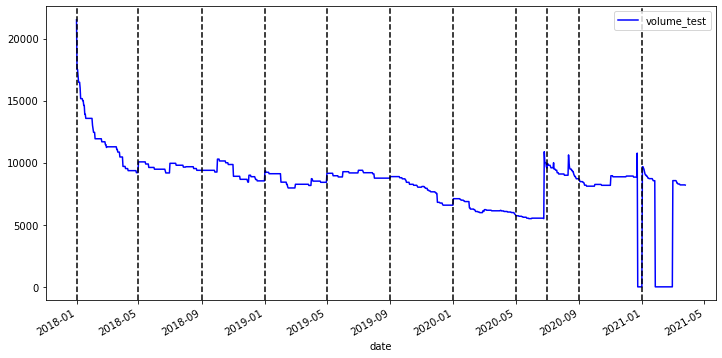

In [50]:
null_time=df.groupby('date')['min_commit'].mean().reset_index(name='mean').sort_values('mean')
ax1 = null_time.plot(x='date', y='mean',color='blue',label='volume_test',figsize=(12,6))
xcoords = ['2018-01-01', '2018-05-01','2018-09-01', '2019-01-01', '2019-05-01', '2019-09-01',
          '2020-01-01','2020-05-01','2020-07-01','2020-09-01','2021-01-01']
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')

In [520]:
numeric_data=numeric_data[['avg_pesq_score','quality_too_poor','number_busy','temporarily_unable_test','outage_sec','numbers_tested','followup_tests','min_commit']]


In [506]:
# generaly before transormation we need to find interactions but we can find later 
# checking with standardscaler is this helps in skewness

scaler = StandardScaler()
stand_nm=scaler.fit_transform(numeric_data)


In [507]:
num_df=pd.DataFrame(stand_nm,columns=['avg_pesq_score','quality_too_poor','number_busy','temporarily_unable_test','outage_sec','numbers_tested','followup_tests','min_commit'])

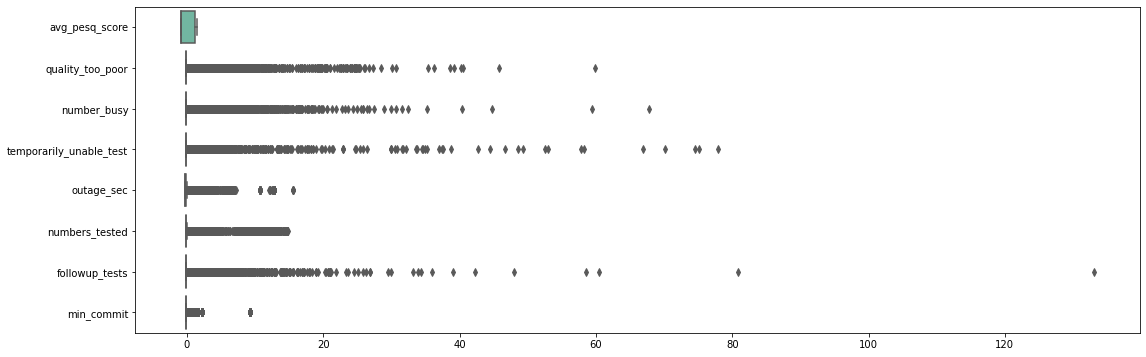

In [508]:
plt.figure(figsize=(18,6))
ax = sns.boxplot(data=num_df, orient="h", palette="Set2")

In [509]:
numeric_data['followup_tests'].value_counts().sort_values()

169        1
164        1
491        1
520        1
219        1
       ...  
4        427
6        545
2        667
3        675
0      99016
Name: followup_tests, Length: 310, dtype: int64

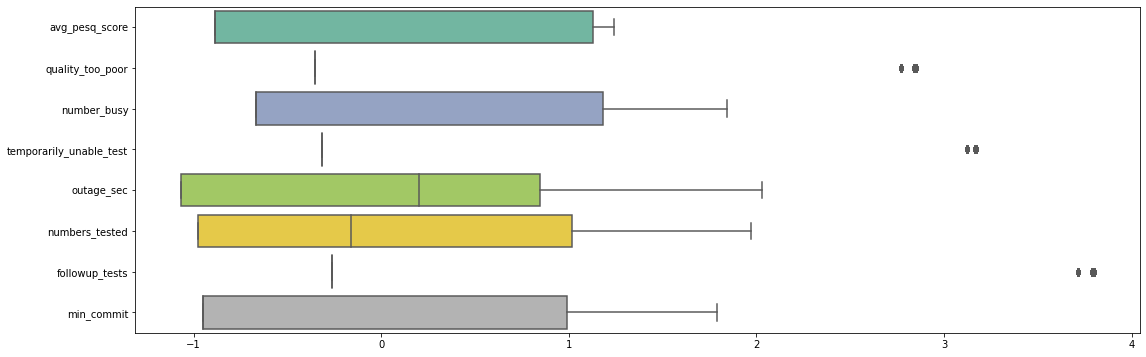

In [510]:
# if yea-johnson is better ?
# it looks better not skewed we can go ahead and remove outiers
yj = PowerTransformer(method="yeo-johnson")
yea_nm = yj.fit(numeric_data).transform(numeric_data)
num_df=pd.DataFrame(yea_nm,columns=['avg_pesq_score','quality_too_poor','number_busy','temporarily_unable_test','outage_sec','numbers_tested','followup_tests','min_commit'])
plt.figure(figsize=(18,6))
ax = sns.boxplot(data=num_df, orient="h", palette="Set2")

In [511]:
def outlier_treatment(datacolumn):
    sorted(datacolumn)
    Q1,Q3 = np.percentile(datacolumn , [25,75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return lower_range,upper_range

lowerbound,upperbound = outlier_treatment(num_df['avg_pesq_score'])
print(num_df[ (num_df['avg_pesq_score'] > upperbound) | (num_df['avg_pesq_score'] < lowerbound)])
num_df.drop(num_df[ (num_df['avg_pesq_score'] > upperbound) | (num_df['avg_pesq_score'] < lowerbound) ].index , inplace=True)



Empty DataFrame
Columns: [avg_pesq_score, quality_too_poor, number_busy, temporarily_unable_test, outage_sec, numbers_tested, followup_tests, min_commit]
Index: []


In [512]:
lowerbound,upperbound = outlier_treatment(num_df['quality_too_poor'])
print(num_df[ (num_df['quality_too_poor'] > upperbound) | (num_df['quality_too_poor'] < lowerbound)].count())
#num_df.drop(num_df[ (num_df['quality_too_poor'] > upperbound) | (num_df['quality_too_poor'] < lowerbound) ].index , inplace=True)
# we can't drop 11 k rows

avg_pesq_score             11830
quality_too_poor           11830
number_busy                11830
temporarily_unable_test    11830
outage_sec                 11830
numbers_tested             11830
followup_tests             11830
min_commit                 11830
dtype: int64


In [513]:
lowerbound,upperbound = outlier_treatment(num_df['temporarily_unable_test'])
print(num_df[ (num_df['temporarily_unable_test'] > upperbound) | (num_df['temporarily_unable_test'] < lowerbound)].count())
#num_df.drop(num_df[ (num_df['temporarily_unable_test'] > upperbound) | (num_df['temporarily_unable_test'] < lowerbound) ].index , inplace=True)


avg_pesq_score             9668
quality_too_poor           9668
number_busy                9668
temporarily_unable_test    9668
outage_sec                 9668
numbers_tested             9668
followup_tests             9668
min_commit                 9668
dtype: int64


In [514]:
lowerbound,upperbound = outlier_treatment(num_df['followup_tests'])
print(num_df[ (num_df['followup_tests'] > upperbound) | (num_df['followup_tests'] < lowerbound)].count())
#num_df.drop(num_df[ (num_df['followup_tests'] > upperbound) | (num_df['followup_tests'] < lowerbound) ].index , inplace=True)


#num_df['numbers_tested']=remove_outlier(num_df,'followup_tests')

avg_pesq_score             6865
quality_too_poor           6865
number_busy                6865
temporarily_unable_test    6865
outage_sec                 6865
numbers_tested             6865
followup_tests             6865
min_commit                 6865
dtype: int64


In [476]:
# we choose not to drop outliers
# as numbers of outliers are more we can try quantile transform also
# this might be more of a business insight decision 
# we try not to remove values as we dont have idea these extreme values are correct
# or incoorect , we will try to accomodate these outliers using 
# transformations
# there two fold issue ... most rows having zero accross and then other hand we have
# huge values , it is the cause of stretched out right skewed data centered at zero
# there is a dilemma to remove zero values or extreme lack of business knoweldge 

In [515]:
df['number_test_types'].value_counts()
# there are 6 types of test counts we will treat this feature as categorical

0    48829
1    29366
2    19477
3     4699
4     2679
5      534
6      297
Name: number_test_types, dtype: int64

In [521]:
#log_transform
scaler = StandardScaler()
a=numeric_data['avg_pesq_score']
b=numeric_data['quality_too_poor']
c=numeric_data['number_busy']
d=numeric_data['temporarily_unable_test']
e=numeric_data['outage_sec']
f=numeric_data['numbers_tested']
g=numeric_data['followup_tests']
h=numeric_data['min_commit']

numeric_data['avg_pesq_score']=scaler.fit_transform(a.values.reshape(-1,1))
numeric_data['quality_too_poor']=scaler.fit_transform(b.values.reshape(-1,1))
numeric_data['number_busy']=scaler.fit_transform(c.values.reshape(-1,1))
numeric_data['temporarily_unable_test']=scaler.fit_transform(d.values.reshape(-1,1))
numeric_data['outage_sec']=scaler.fit_transform(e.values.reshape(-1,1))
numeric_data['numbers_tested']=scaler.fit_transform(f.values.reshape(-1,1))
numeric_data['followup_tests']=scaler.fit_transform(g.values.reshape(-1,1))
numeric_data['min_commit']=scaler.fit_transform(h.values.reshape(-1,1))

numeric_data['avg_pesq_score']=np.log1p(a)
numeric_data['quality_too_poor']=np.log1p(b)
numeric_data['number_busy']=np.log1p(c)
numeric_data['temporarily_unable_test']=np.log1p(d)
numeric_data['outage_sec']=np.log1p(e)
numeric_data['numbers_tested']=np.log1p(f)
numeric_data['followup_tests']=np.log1p(g)
numeric_data['min_commit']=np.log1p(h)
numeric_data.head()

#num_df=pd.DataFrame(yea_nm,columns=['avg_pesq_score','quality_too_poor','number_busy','temporarily_unable_test','outage_sec','numbers_tested','followup_tests','min_commit'])
#plt.figure(figsize=(18,6))
#ax = sns.boxplot(data=num_df, orient="h", palette="Set2")

,avg_pesq_score,quality_too_poor,number_busy,temporarily_unable_test,outage_sec,numbers_tested,followup_tests,min_commit
0,0.836743,0.693147,4.465908,0.0,1.469737,7.848934,0.000000,1.158246
1,0.718391,1.609438,5.509388,0.0,0.642988,7.787797,4.615121,2.332426
2,-2.144953,0.000000,0.693147,0.0,-0.364726,5.337538,0.000000,-0.165960
3,0.787357,0.000000,0.000000,0.0,0.072370,4.143135,0.000000,-0.054355
4,0.633009,0.000000,0.000000,0.0,-0.364726,2.639057,0.000000,-0.208886


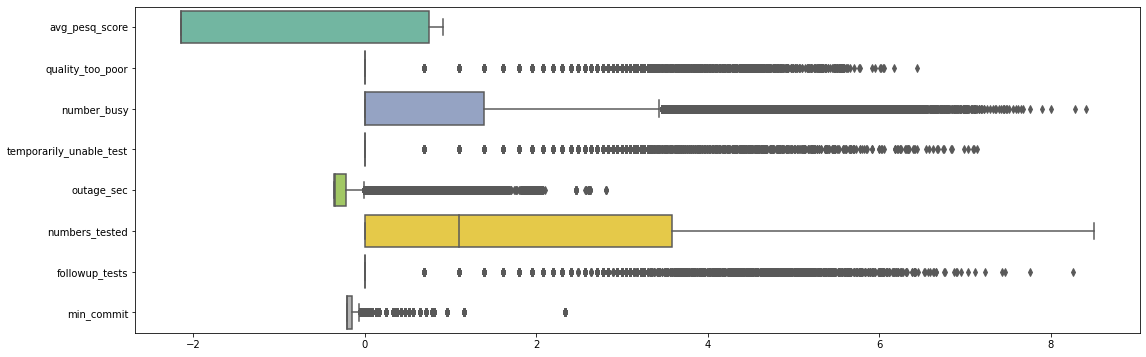

In [522]:
#num_df=pd.DataFrame(numeric_data,columns=['avg_pesq_score','quality_too_poor','number_busy','temporarily_unable_test','outage_sec','numbers_tested','followup_tests','min_commit'])
plt.figure(figsize=(18,6))
ax = sns.boxplot(data=numeric_data, orient="h", palette="Set2")
# log transform we might do at the with target also to get log log regression coefficients

# Multivariate analysis

In [8]:
# adding more features for analysis
df['week'] = pd.to_datetime(df['date']).dt.week
df['Day_of_week'] = pd.to_datetime(df['date']).dt.day_name()
df['Year'] = pd.to_datetime(df['date']).dt.year
df['Month'] = pd.to_datetime(df['date']).dt.month

C:\Users\KARAMJ~1\AppData\Local\Temp/ipykernel_2276/1789150361.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['week'] = pd.to_datetime(df['date']).dt.week


In [12]:
df.describe()

,company_id,avg_pesq_score,quality_too_poor,number_busy,temporarily_unable_test,outage_sec,number_test_types,numbers_tested,followup_tests,min_commit,has_min_commit,volume_tests,is_testing,week,Year,Month
count,105881.000000,105881.000000,105881.000000,105881.000000,105881.000000,105881.000000,105881.000000,105881.000000,105881.000000,105881.000000,105881.00000,105881.000000,105881.000000,105881.000000,105881.000000,105881.000000
mean,123.872366,1.685454,1.279380,12.573219,1.251263,558.766729,0.921648,67.953193,2.854299,7944.551421,0.48767,707.579641,0.639709,25.898197,2019.305928,6.329502
std,90.086449,1.908950,10.452038,66.028674,16.123530,1828.356203,1.093184,329.480761,28.863829,42143.533507,0.49985,4135.667318,0.480087,15.532299,0.865002,3.551739
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,2018.000000,1.000000
25%,56.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,12.000000,2019.000000,3.000000
50%,116.000000,0.000000,0.000000,0.000000,0.000000,24.000000,1.000000,2.000000,0.000000,0.000000,0.00000,26.000000,1.000000,25.000000,2019.000000,6.000000
75%,186.000000,3.822915,0.000000,3.000000,0.000000,192.000000,2.000000,35.000000,0.000000,2000.000000,1.00000,196.000000,1.000000,40.000000,2020.000000,10.000000
max,450.000000,4.500000,627.000000,4492.000000,1258.000000,29111.660000,6.000000,4927.000000,3844.000000,400000.000000,1.00000,57105.000000,1.000000,53.000000,2021.000000,12.000000


company_type
Carrier       2.574914
Conference    2.683724
Enterprise    1.537635
Name: avg_pesq_score, dtype: float64

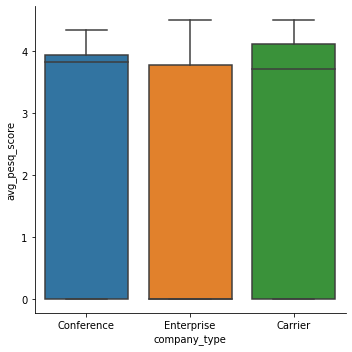

In [13]:
#first company_type with all other features
# outlier check
sns.catplot(x="company_type", y="avg_pesq_score", kind="box", data=df)
df.groupby('company_type')['avg_pesq_score'].mean()
# average audio quality metric for enterprise is less compared to carrier and conference

<AxesSubplot:xlabel='avg_pesq_score', ylabel='Count'>

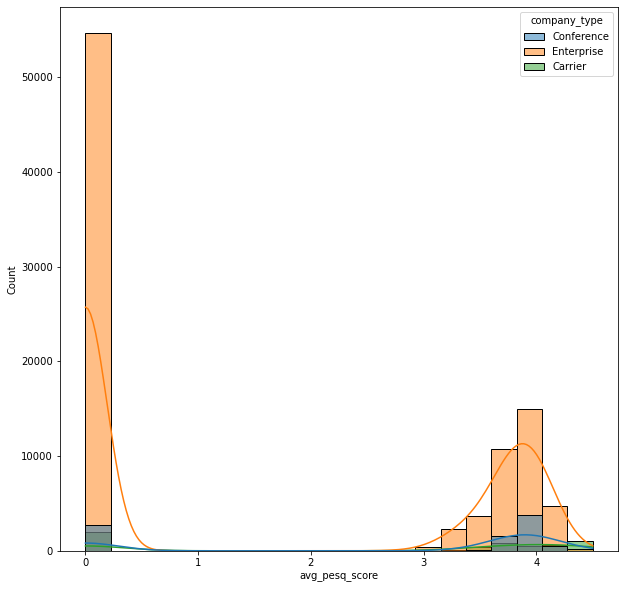

In [8]:
f,ax=plt.subplots(1,1,figsize=(10, 10))
sns.histplot(x=df['avg_pesq_score'],data=df,ax=ax,hue='company_type',bins=20,kde=True)
# it shows bimodal being zero avg_pesq_score is most likely a flaw missing data
# or some business rule behind it 

                counts  percentage
company_type                      
Carrier        3335367    4.451950
Conference     8951128   11.947703
Enterprise    62632745   83.600348
            counts  percentage
Enterprise   91699   86.605718
Conference    8644    8.163882
Carrier       5538    5.230400


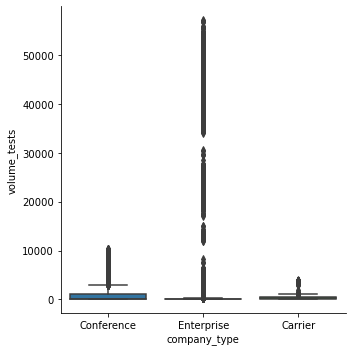

In [547]:
# outlier check
sns.catplot(x="company_type", y="volume_tests", kind="box", data=df)
analysis=df.groupby('company_type')['volume_tests'].sum()
analysis.transform(lambda x:100 * x / float(x.sum()))

analysis = pd.concat([analysis,analysis.transform(lambda x:100 * x / float(x.sum()))],axis=1,keys=('counts','percentage'))
print (analysis)

analysis = df['company_type']
analysis = pd.concat([analysis.value_counts(),analysis.value_counts(normalize=True).mul(100)],axis=1,keys=('counts','percentage'))
print (analysis)
# by % enterprise is 86% it brings 83% volume test
# Conference company are less but they do volume test than carrier

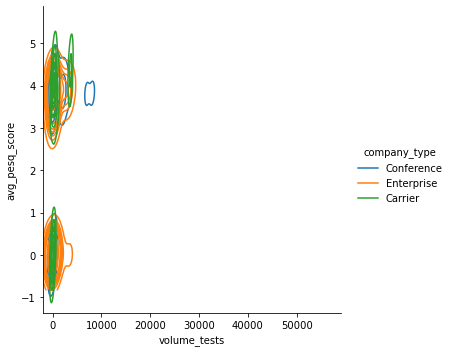

In [6]:
# company type with volume test and avg_pecscore
# dist plot loads of time we will use relplot instead
# Interaction Check
# we can see conference we have good sepration if we use avg_pesqscore with company type
sns.displot(df, x=df['volume_tests'], y=df['avg_pesq_score'], hue='company_type', kind="kde")

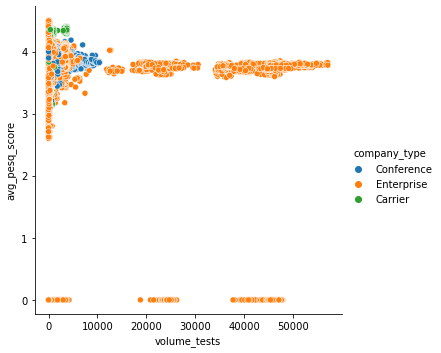

In [8]:
sns.relplot(x=df['volume_tests'], y=df['avg_pesq_score'], hue='company_type', data=df);

               counts  percentage
company_type                     
Carrier         48791    3.665010
Conference     153257   11.512133
Enterprise    1129217   84.822856


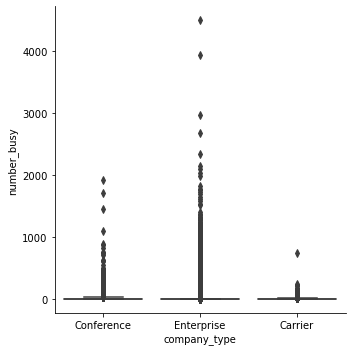

In [551]:
# outliers check
sns.catplot(x="company_type", y="number_busy", kind="box", data=df)
analysis=df.groupby('company_type')['number_busy'].sum()
analysis.transform(lambda x:100 * x / float(x.sum()))

analysis = pd.concat([analysis,analysis.transform(lambda x:100 * x / float(x.sum()))],axis=1,keys=('counts','percentage'))
print (analysis)

# test volume and number of test busy almost same percentage 
# combination of these two variables will be a important one

<AxesSubplot:xlabel='number_busy', ylabel='Count'>

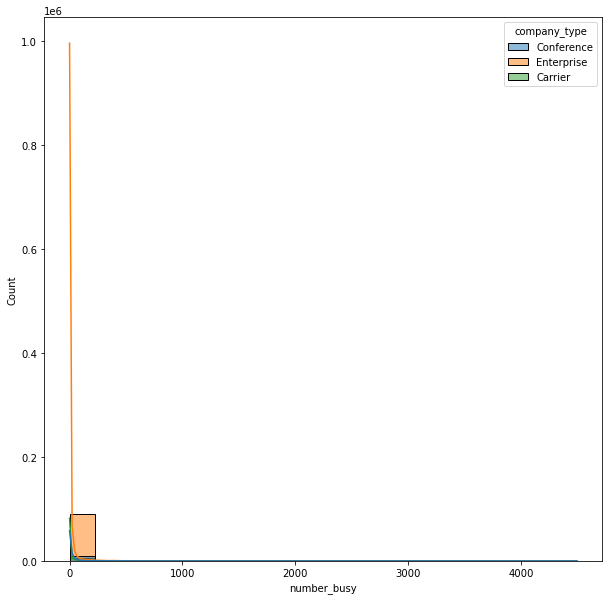

In [11]:
# distribution check
# all skewed 
f,ax=plt.subplots(1,1,figsize=(10, 10))
sns.histplot(x=df['number_busy'],data=df,ax=ax,hue='company_type',bins=20,kde=True)

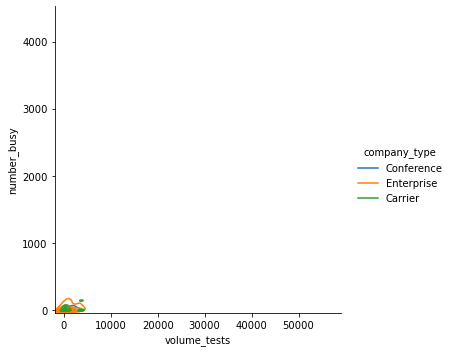

In [10]:
# Interaction Check
# we can see number busy not good interaction with company type
sns.displot(df, x=df['volume_tests'], y=df['number_busy'], hue='company_type', kind="kde")

              counts  percentage
company_type                    
Carrier         4244    3.132982
Conference     40399   29.823124
Enterprise     90819   67.043894


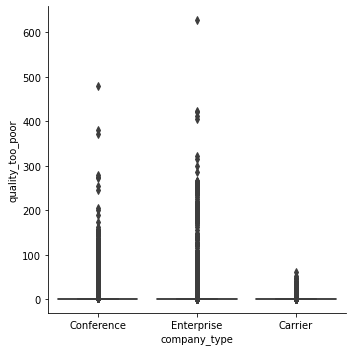

In [552]:
# outliers check
sns.catplot(x="company_type", y="quality_too_poor", kind="box", data=df)
analysis=df.groupby('company_type')['quality_too_poor'].sum()
analysis.transform(lambda x:100 * x / float(x.sum()))

analysis = pd.concat([analysis,analysis.transform(lambda x:100 * x / float(x.sum()))],axis=1,keys=('counts','percentage'))
print (analysis)
# enterprise has most poor quality tests
# conference have more than carrier

<AxesSubplot:xlabel='quality_too_poor', ylabel='Count'>

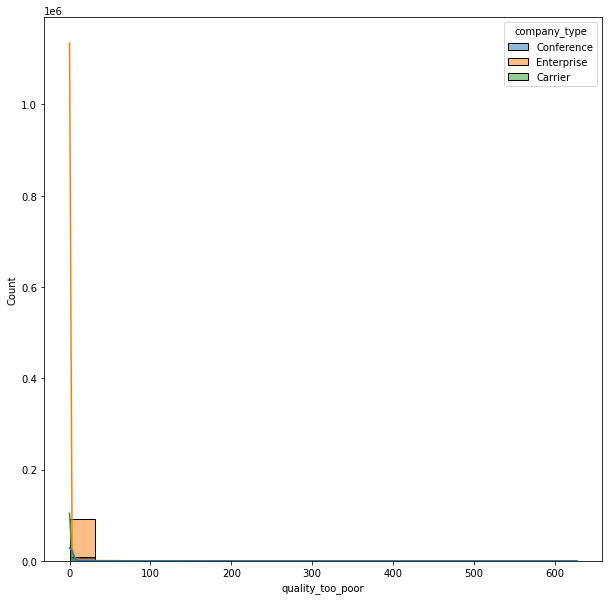

In [12]:
# distribution check
f,ax=plt.subplots(1,1,figsize=(10, 10))
sns.histplot(x=df['quality_too_poor'],data=df,ax=ax,hue='company_type',bins=20,kde=True)

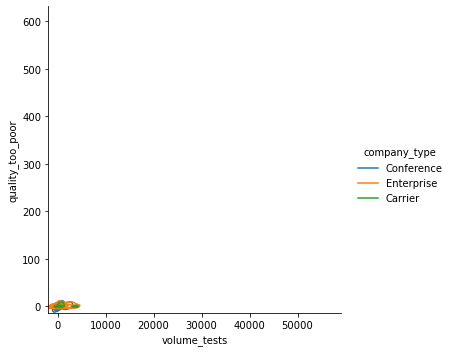

In [13]:
# Interaction Check
# we can see quality_too_poor not good interaction with company type
sns.displot(df, x=df['volume_tests'], y=df['quality_too_poor'], hue='company_type', kind="kde")

              counts  percentage
company_type                    
Carrier         9905    7.476318
Conference     17698   13.358493
Enterprise    104882   79.165189


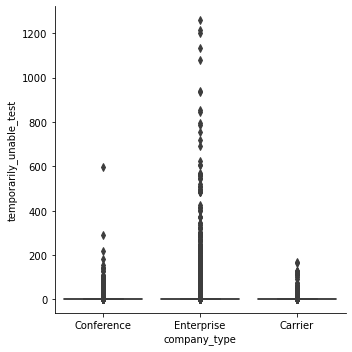

In [553]:
sns.catplot(x="company_type", y="temporarily_unable_test", kind="box", data=df)
analysis=df.groupby('company_type')['temporarily_unable_test'].sum()
analysis.transform(lambda x:100 * x / float(x.sum()))

analysis = pd.concat([analysis,analysis.transform(lambda x:100 * x / float(x.sum()))],axis=1,keys=('counts','percentage'))
print (analysis)
# as expected who test more face more chances of unable to do test

<AxesSubplot:xlabel='temporarily_unable_test', ylabel='Count'>

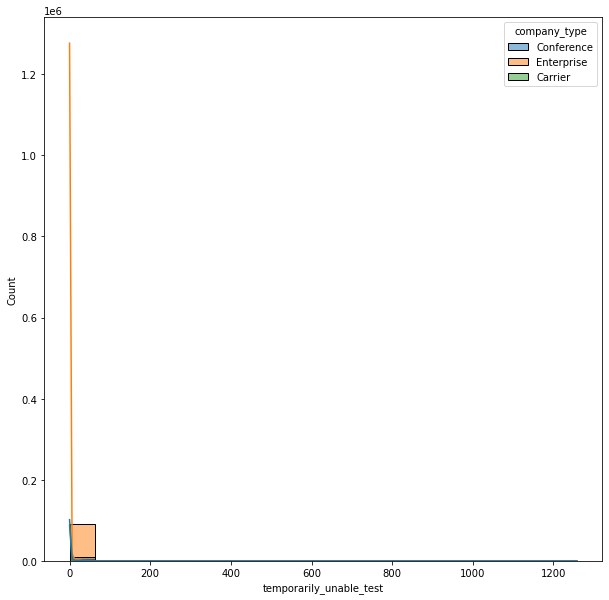

In [14]:
# distribution check
f,ax=plt.subplots(1,1,figsize=(10, 10))
sns.histplot(x=df['temporarily_unable_test'],data=df,ax=ax,hue='company_type',bins=20,kde=True)

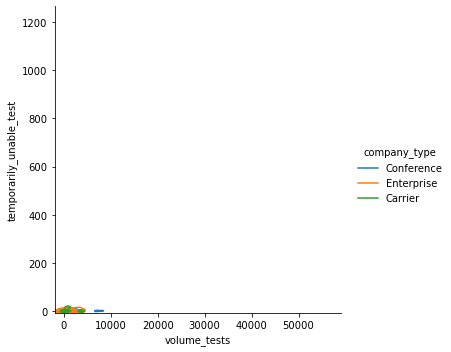

In [15]:
# Interaction Check
# we can see temporarily_unable_test  good interaction with company type conference
sns.displot(df, x=df['volume_tests'], y=df['temporarily_unable_test'], hue='company_type', kind="kde")

                   counts  percentage
company_type                         
Carrier        2759309.11    4.663927
Conference    13762057.74   23.261344
Enterprise    42641413.21   72.074729


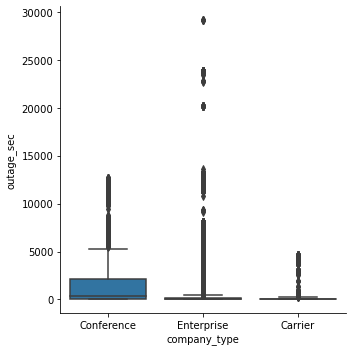

In [554]:
sns.catplot(x="company_type", y="outage_sec", kind="box", data=df)
analysis=df.groupby('company_type')['outage_sec'].sum()
analysis.transform(lambda x:100 * x / float(x.sum()))

analysis = pd.concat([analysis,analysis.transform(lambda x:100 * x / float(x.sum()))],axis=1,keys=('counts','percentage'))
print (analysis)

<AxesSubplot:xlabel='outage_sec', ylabel='Count'>

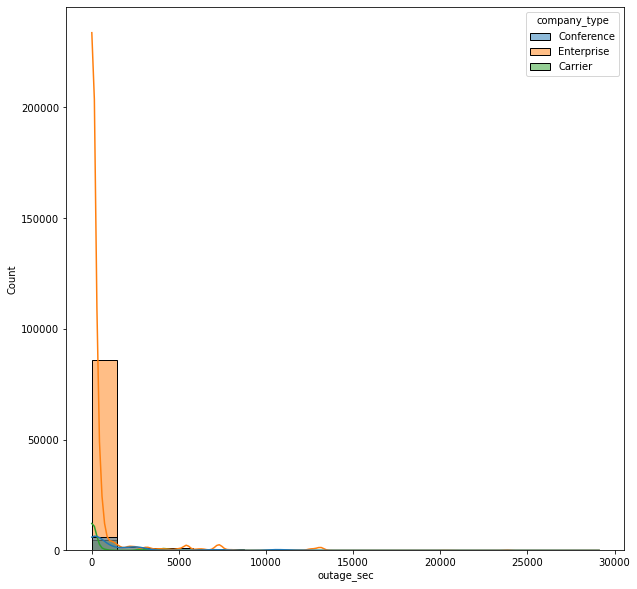

In [16]:
# distribution check
f,ax=plt.subplots(1,1,figsize=(10, 10))
sns.histplot(x=df['outage_sec'],data=df,ax=ax,hue='company_type',bins=20,kde=True)

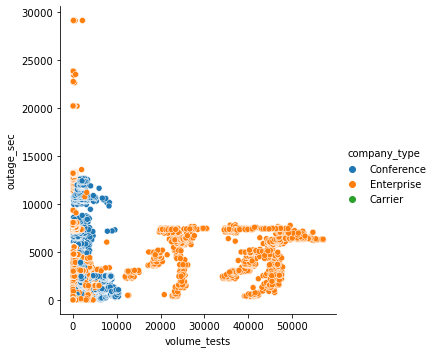

In [12]:
# Interaction Check
# we can see outage_sec not good interaction with company type
sns.relplot(data=df, x=df['volume_tests'], y=df['outage_sec'], hue='company_type');

               counts  percentage
company_type                     
Carrier        238992    3.321662
Conference    1058933   14.717722
Enterprise    5897027   81.960616


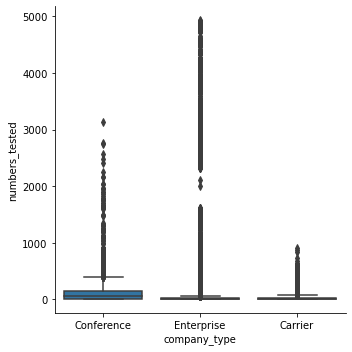

In [555]:
sns.catplot(x="company_type", y="numbers_tested", kind="box", data=df)
analysis=df.groupby('company_type')['numbers_tested'].sum()
analysis.transform(lambda x:100 * x / float(x.sum()))

analysis = pd.concat([analysis,analysis.transform(lambda x:100 * x / float(x.sum()))],axis=1,keys=('counts','percentage'))
print (analysis)
#numbers_tested,followup_tests,min_commit

<AxesSubplot:xlabel='numbers_tested', ylabel='Count'>

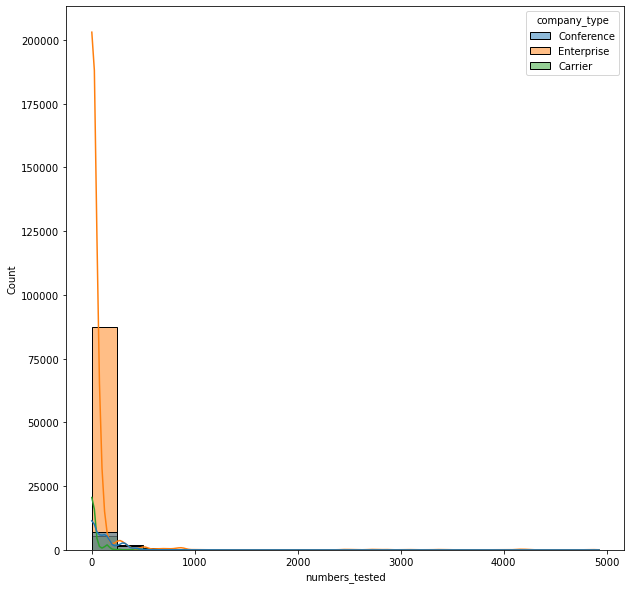

In [17]:
# distribution check
f,ax=plt.subplots(1,1,figsize=(10, 10))
sns.histplot(x=df['numbers_tested'],data=df,ax=ax,hue='company_type',bins=20,kde=True)

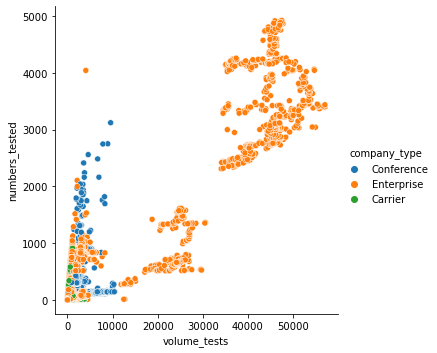

In [13]:
# Interaction Check
# we can see numbers_tested  good interaction with company type
sns.relplot(data=df, x=df['volume_tests'], y=df['numbers_tested'], hue='company_type');

              counts  percentage
company_type                    
Carrier           64    0.021177
Conference     25073    8.296384
Enterprise    277079   91.682439


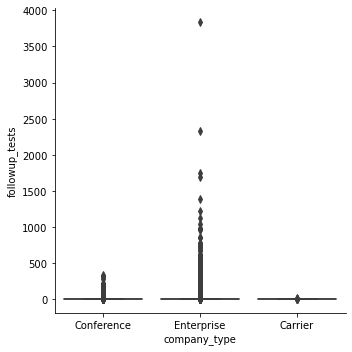

In [556]:
sns.catplot(x="company_type", y="followup_tests", kind="box", data=df)
analysis=df.groupby('company_type')['followup_tests'].sum()
analysis.transform(lambda x:100 * x / float(x.sum()))

analysis = pd.concat([analysis,analysis.transform(lambda x:100 * x / float(x.sum()))],axis=1,keys=('counts','percentage'))
print (analysis)
# enterprise does the most follow up test , suprisingly carrier doesn't do that much


<AxesSubplot:xlabel='followup_tests', ylabel='Count'>

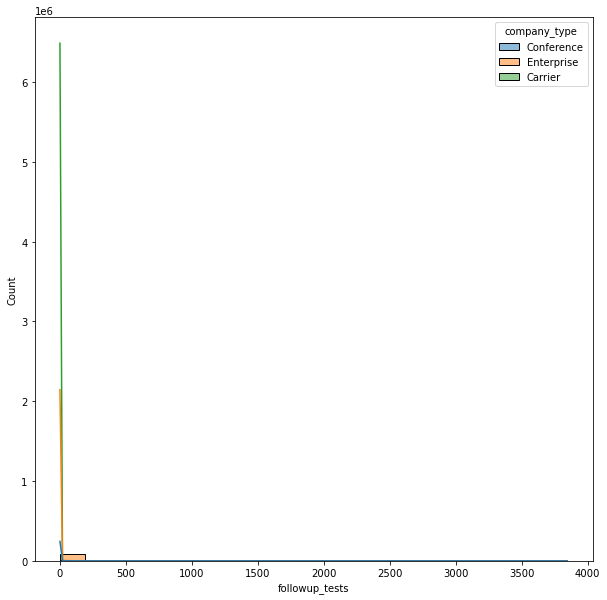

In [18]:
# distribution check
f,ax=plt.subplots(1,1,figsize=(10, 10))
sns.histplot(x=df['followup_tests'],data=df,ax=ax,hue='company_type',bins=20,kde=True)

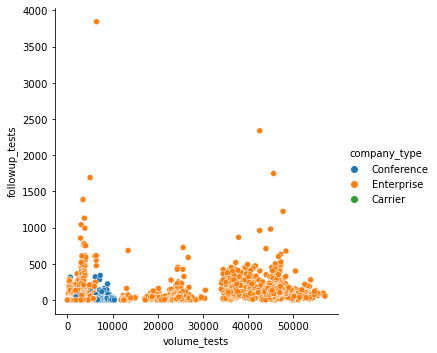

In [14]:
# Interaction Check
# we can see followup_tests  good interaction with company type
sns.relplot(data=df, x=df['volume_tests'], y=df['followup_tests'], hue='company_type');

                   counts  percentage
company_type                         
Carrier        37542748.0    4.463121
Conference     82152329.0    9.766354
Enterprise    721481972.0   85.770525


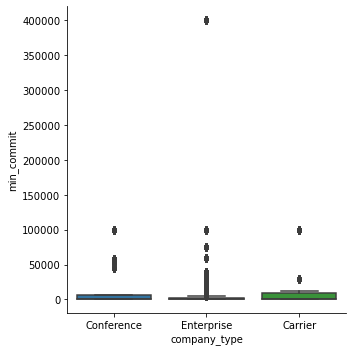

In [557]:
sns.catplot(x="company_type", y="min_commit", kind="box", data=df)
analysis=df.groupby('company_type')['min_commit'].sum()
analysis.transform(lambda x:100 * x / float(x.sum()))

analysis = pd.concat([analysis,analysis.transform(lambda x:100 * x / float(x.sum()))],axis=1,keys=('counts','percentage'))
print (analysis)
# max commit done by enterprise


<AxesSubplot:xlabel='min_commit', ylabel='Count'>

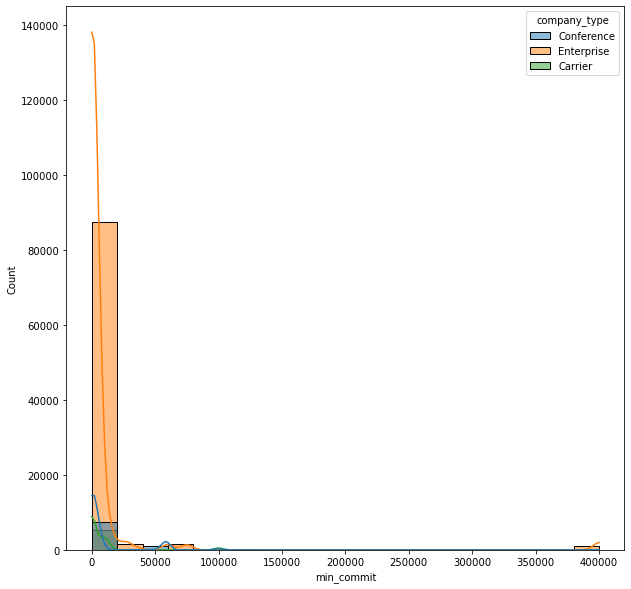

In [19]:
# distribution check
f,ax=plt.subplots(1,1,figsize=(10, 10))
sns.histplot(x=df['min_commit'],data=df,ax=ax,hue='company_type',bins=20,kde=True)

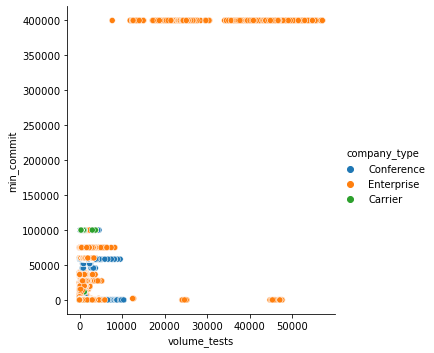

In [15]:
# Interaction Check
# we can see min_commit  good interaction with company type
sns.relplot(data=df, x=df['volume_tests'], y=df['min_commit'], hue='company_type');

In [ ]:
# summary : carrier : test volume is least, number of company are also less , second best score metric but not by much ,
# very realy we can see followups
# conference has highest outage and highes metric score


In [20]:
# we can check which company id has max or min values attached to them .
max_index = df['volume_tests'].idxmax()
df.loc[max_index]
# 57k in 2019 done by enterprise company
# we can drill down on this company if we need to get other general trends , it would be too exhaustive 
# for now

company_id                                   2
company_type                        Enterprise
date                       2019-07-02 00:00:00
avg_pesq_score                        3.794042
quality_too_poor                            13
number_busy                                145
temporarily_unable_test                      0
outage_sec                             6243.37
number_test_types                            4
numbers_tested                            3397
followup_tests                              68
min_commit                            400000.0
has_min_commit                               1
volume_tests                             57105
is_testing                                   1
week                                        27
Day_of_week                            Tuesday
Year                                      2019
Month                                        7
Name: 38234, dtype: object

In [23]:
max_index = df['avg_pesq_score'].idxmax()
df.loc[max_index]
# carrier has the highest score in 2019

company_id                                 165
company_type                           Carrier
date                       2019-06-24 00:00:00
avg_pesq_score                             4.5
quality_too_poor                             0
number_busy                                 85
temporarily_unable_test                      0
outage_sec                                96.0
number_test_types                            1
numbers_tested                               1
followup_tests                               0
min_commit                                 0.0
has_min_commit                               0
volume_tests                               153
is_testing                                   1
week                                        26
Day_of_week                             Monday
Year                                      2019
Month                                        6
Name: 37549, dtype: object

In [24]:
max_index = df['quality_too_poor'].idxmax()
df.loc[max_index]
# enterprise

company_id                                   2
company_type                        Enterprise
date                       2018-06-27 00:00:00
avg_pesq_score                        3.806793
quality_too_poor                           627
number_busy                                469
temporarily_unable_test                     68
outage_sec                             4353.67
number_test_types                            3
numbers_tested                            2718
followup_tests                             130
min_commit                            400000.0
has_min_commit                               1
volume_tests                             40609
is_testing                                   1
week                                        26
Day_of_week                          Wednesday
Year                                      2018
Month                                        6
Name: 9282, dtype: object

In [25]:
max_index = df['followup_tests'].idxmax()
df.loc[max_index]
# again enterprise we can do this all day but wont continue 

company_id                                  49
company_type                        Enterprise
date                       2021-01-16 00:00:00
avg_pesq_score                        3.890066
quality_too_poor                             0
number_busy                               3936
temporarily_unable_test                      0
outage_sec                             3034.33
number_test_types                            2
numbers_tested                             667
followup_tests                            3844
min_commit                             75000.0
has_min_commit                               1
volume_tests                              6422
is_testing                                   1
week                                         2
Day_of_week                           Saturday
Year                                      2021
Month                                        1
Name: 101305, dtype: object

        counts  percentage
Month                     
1      4929069    7.044458
2      4487164    6.412902
3      5386956    7.698854
4      5721335    8.176737
5      5747679    8.214387
6      5696282    8.140933
7      6362476    9.093034
8      6278259    8.972674
9      6142802    8.779084
10     6613343    9.451565
11     6344492    9.067332
12     6261021    8.948038


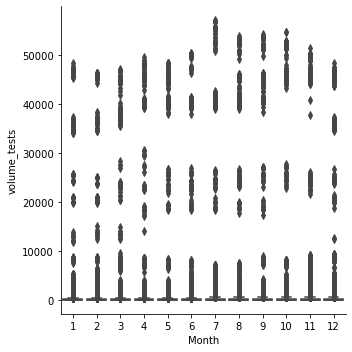

In [21]:
pr=df[(df['Year']!=2021)]
sns.catplot(x="Month", y="volume_tests", kind="box", data=pr)
analysis=pr.groupby('Month')['volume_tests'].sum()
analysis.transform(lambda x:100 * x / float(x.sum()))

analysis = pd.concat([analysis,analysis.transform(lambda x:100 * x / float(x.sum()))],axis=1,keys=('counts','percentage'))
print (analysis)

# year end we generally have more tests , interaction might be important

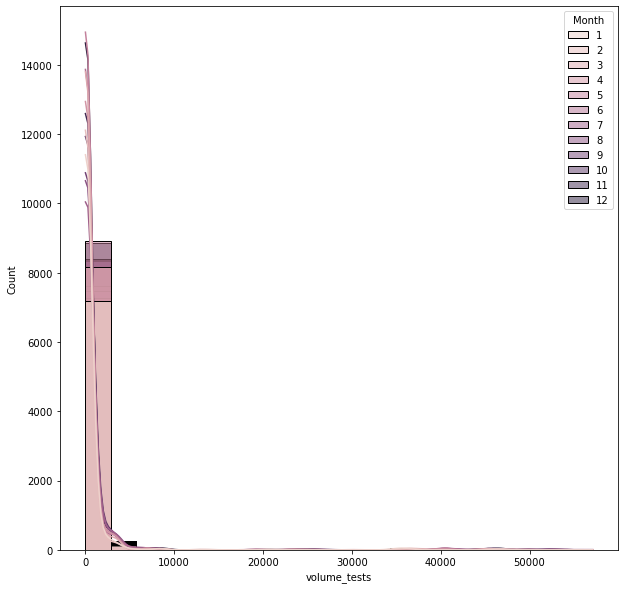

In [24]:
# distribution check
f,ax=plt.subplots(1,1,figsize=(10, 10))
sns.histplot(x=pr['volume_tests'],data=pr,ax=ax,hue='Month',bins=20,kde=True);

               counts  percentage
Day_of_week                      
Friday       12221047   16.312294
Monday       12379991   16.524448
Saturday      6325546    8.443153
Sunday        6327326    8.445529
Thursday     12530640   16.725530
Tuesday      12498178   16.682201
Wednesday    12636512   16.866845


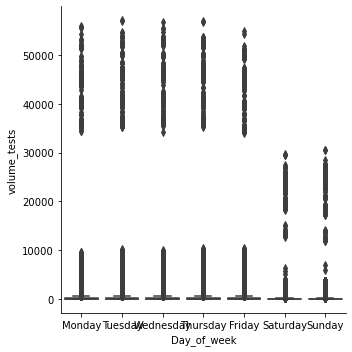

In [50]:

sns.catplot(x="Day_of_week", y="volume_tests", kind="box", data=df)
analysis=df.groupby('Day_of_week')['volume_tests'].sum()
analysis.transform(lambda x:100 * x / float(x.sum()))

analysis = pd.concat([analysis,analysis.transform(lambda x:100 * x / float(x.sum()))],axis=1,keys=('counts','percentage'))
print (analysis)
# weekend seems to be a very important indicator



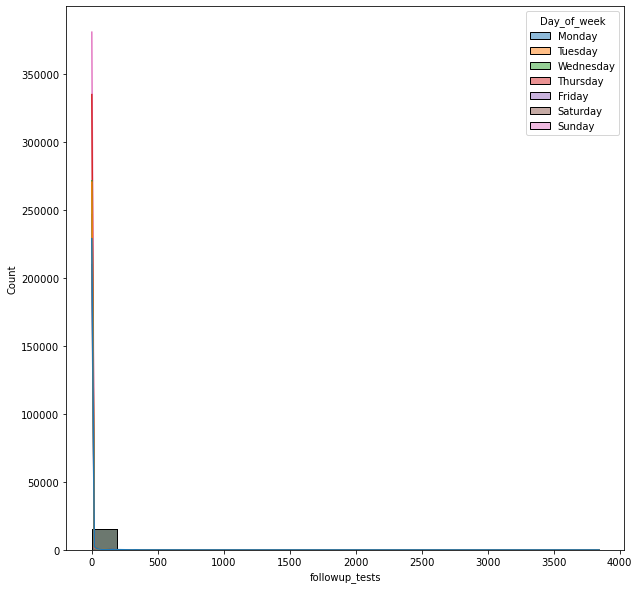

In [25]:
# distribution check
f,ax=plt.subplots(1,1,figsize=(10, 10))
sns.histplot(x=df['followup_tests'],data=df,ax=ax,hue='Day_of_week',bins=20,kde=True);

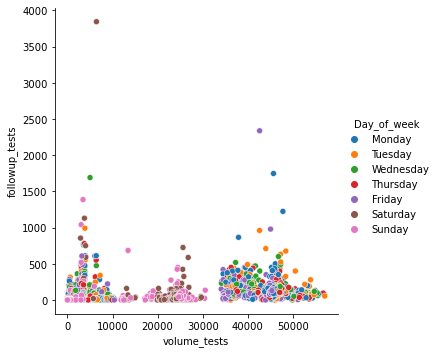

In [26]:
# Interaction Check
# we can see Day_of_week  good interaction with followup_tests 
sns.relplot(data=df, x=df['volume_tests'], y=df['followup_tests'], hue='Day_of_week');

             counts  percentage
Day_of_week                    
Friday        48256   15.967388
Monday        58937   19.501615
Saturday      25815    8.541904
Sunday        23477    7.768285
Thursday      45067   14.912182
Tuesday       50998   16.874686
Wednesday     49666   16.433941


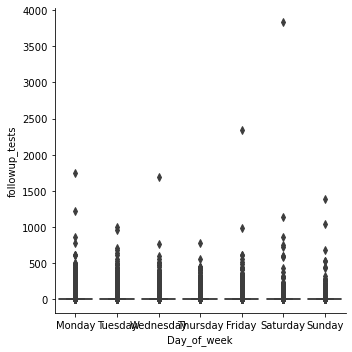

In [51]:

sns.catplot(x="Day_of_week", y="followup_tests", kind="box", data=df)
analysis=df.groupby('Day_of_week')['followup_tests'].sum()
analysis.transform(lambda x:100 * x / float(x.sum()))

analysis = pd.concat([analysis,analysis.transform(lambda x:100 * x / float(x.sum()))],axis=1,keys=('counts','percentage'))
print (analysis)
# most follow ups are done on monday , weekend very less


                  counts  percentage
Day_of_week                         
Friday       120282796.0   14.299344
Monday       121055186.0   14.391166
Saturday     120311318.0   14.302734
Sunday       120349100.0   14.307226
Thursday     119423306.0   14.197166
Tuesday      120264796.0   14.297204
Wednesday    119490547.0   14.205160


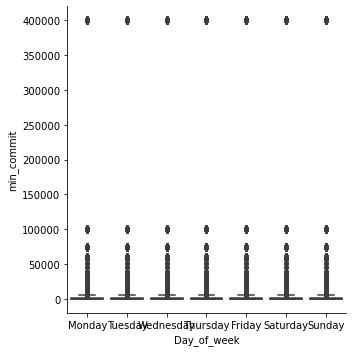

In [52]:
sns.catplot(x="Day_of_week", y="min_commit", kind="box", data=df)
analysis=df.groupby('Day_of_week')['min_commit'].sum()
analysis.transform(lambda x:100 * x / float(x.sum()))

analysis = pd.concat([analysis,analysis.transform(lambda x:100 * x / float(x.sum()))],axis=1,keys=('counts','percentage'))
print (analysis)

# min_commit is constant

In [60]:

data_crosstab = pd.crosstab(df['company_type'],
                            df['number_test_types'], 
                               margins = False)
print(data_crosstab)
# check chi score for both


number_test_types      0      1      2     3     4    5    6
company_type                                                
Carrier             1312   1137   2001   399   689    0    0
Conference          2649   1897   1601  1880   548   68    1
Enterprise         44868  26332  15875  2420  1442  466  296


In [62]:
stat, p, dof, expected = chi2_contingency(data_crosstab)
# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)')


p value is 0.0
Dependent (reject H0)


In [64]:
df.head()

,company_id,company_type,date,avg_pesq_score,quality_too_poor,number_busy,temporarily_unable_test,outage_sec,number_test_types,numbers_tested,followup_tests,min_commit,has_min_commit,volume_tests,is_testing,week,Day_of_week,Year,Month
0,1,Conference,2018-01-01,4.183942,1,86,0,6680.24,2,2562,0,100000.0,1,4590,1,1,Monday,2018,1
1,2,Enterprise,2018-01-01,3.692000,4,246,0,2208.22,2,2410,100,400000.0,1,35405,1,1,Monday,2018,1
2,4,Enterprise,2018-01-01,0.000000,0,1,0,0.00,1,207,0,1500.0,1,302,1,1,Monday,2018,1
3,6,Conference,2018-01-01,3.971564,0,0,0,695.99,2,62,0,5715.0,1,167,1,1,Monday,2018,1
4,10,Enterprise,2018-01-01,3.371562,0,0,0,0.00,1,13,0,0.0,0,672,1,1,Monday,2018,1


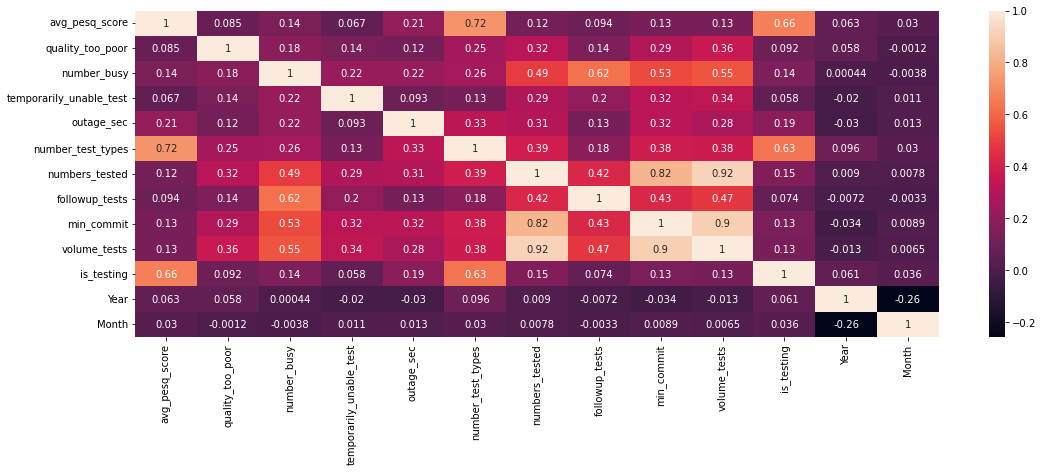

In [68]:
analysis=df[['company_type','avg_pesq_score','quality_too_poor','number_busy','temporarily_unable_test','outage_sec','number_test_types','numbers_tested','followup_tests','min_commit','volume_tests','is_testing','Day_of_week','Year','Month']]
plt.figure(figsize=(18,6))
ax = sns.heatmap(analysis.corr(), annot=True)
# avg_score is correlated with number_test_type and is_testing
# number_tested and volume_tested seems to be to much correlated and are like feature leakage 
# number_tested and min_commit are also very corelated

In [29]:
# we can get mutual score between also to get features relation
# among and with target also

# below code i use generally for filtering features but we can also use for
# feature relation using Annova and Mutal information( entropy) with target
class simple_filter():
    def __init__(self,n_features,problem_type,scoring):
        # for classification : f_classify , chi2 ans mutual_info
        # for regression : f_regression and mutual regression
        if problem_type == 'classification':
            valid_scoring={'f_classif':f_classif,'chi2':chi2,'mutual_info_classif':mutual_info_classif}
        else:
            valid_scoring={'f_regression':f_regression,'mutual_info_regression':mutual_info_regression}
        if scoring not in valid_scoring:
            raise Exception ("Invalid Scoring Method")
        # if n_features is int then selectkbest
        # if n_features is float then selectpercentile
        if isinstance(n_features,int):
            self.selection=SelectKBest(valid_scoring[scoring],k=n_features)
        elif isinstance(n_features,float):
            self.selection=Selectpercentile(valid_scoring[scoring],k=n_features)
    def fit(self,X,Y):
        return self.selection.fit(X,Y)
    def transform(self,X):
        return self.selection.transform(x)

In [31]:
sim=simple_filter(n_features=8,problem_type='regression',scoring='f_regression')
pp=sim.fit(df[num_cols],df['volume_tests'])

<AxesSubplot:>

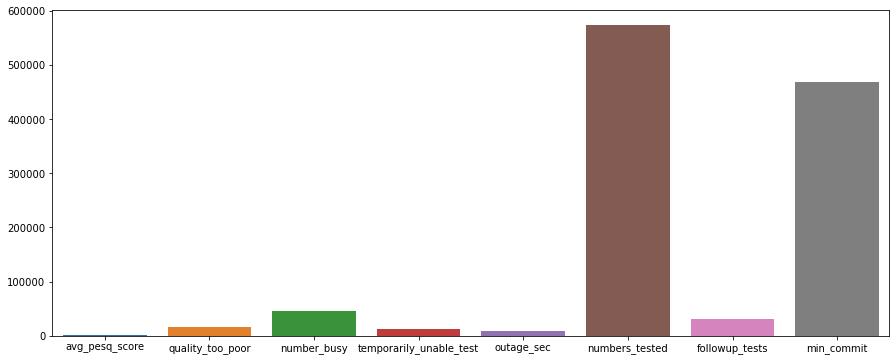

In [35]:
f,ax=plt.subplots(1,1,figsize=(15, 6))
sns.barplot(x=df[num_cols].columns,y=pp.scores_,ax=ax)
# number_tested, min_commit , number_busy are the top number busy very low third score
# this tell us linear relation between target and features 

In [36]:
sim=simple_filter(n_features=8,problem_type='regression',scoring='mutual_info_regression')
mt=sim.fit(df[num_cols],df['volume_tests'])

<AxesSubplot:>

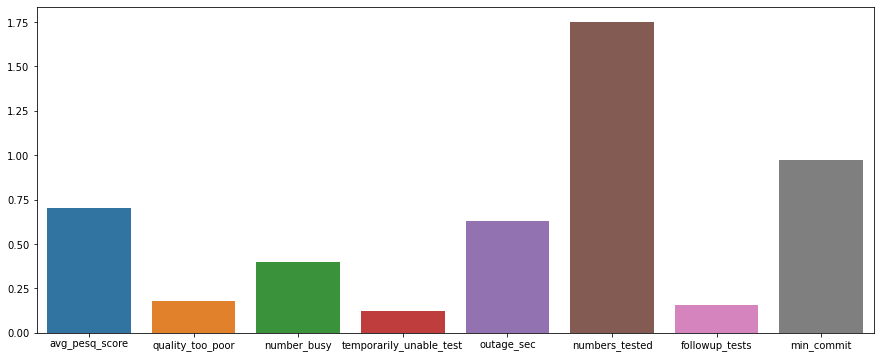

In [37]:
f,ax=plt.subplots(1,1,figsize=(15, 6))
sns.barplot(x=df[num_cols].columns,y=mt.scores_,ax=ax)
# As we can see this brings out non-linear relation
# mutual information is how much info we can get about target if we know that feature
# this shows some features might need to be non linear transformed 

# Basic regression


In [30]:
num_cols = ['avg_pesq_score','quality_too_poor','number_busy','temporarily_unable_test',
              'outage_sec','numbers_tested','followup_tests','min_commit']
df[num_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105881 entries, 0 to 105880
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   avg_pesq_score           105881 non-null  float64
 1   quality_too_poor         105881 non-null  int64  
 2   number_busy              105881 non-null  int64  
 3   temporarily_unable_test  105881 non-null  int64  
 4   outage_sec               105881 non-null  float64
 5   numbers_tested           105881 non-null  int64  
 6   followup_tests           105881 non-null  int64  
 7   min_commit               105881 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 11.3 MB



# Basic regression for feature importance

In [83]:
predictors = ['avg_pesq_score','quality_too_poor','number_busy','temporarily_unable_test',
              'outage_sec','numbers_tested','followup_tests','min_commit']
outcome = 'volume_tests'
reg = LinearRegression()
reg.fit(df[predictors], df[outcome])

print(f'Intercept: {reg.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(predictors, reg.coef_):
    print(f' {name}: {coef}')


Intercept: -119.025
Coefficients:
 avg_pesq_score: 9.054419011743253
 quality_too_poor: 25.035316443542246
 number_busy: 3.0159084065630815
 temporarily_unable_test: 7.239237492694084
 outage_sec: -0.09434561093579674
 numbers_tested: 6.493732029169401
 followup_tests: 4.470791670926475
 min_commit: 0.041666645580537676


In [84]:
fitted = reg.predict(df[predictors])
RMSE = np.sqrt(mean_squared_error(df[outcome], fitted))
r2 = r2_score(df[outcome], fitted)
print(f'RMSE: {RMSE:.0f}')
print(f'r2: {r2:.4f}')

RMSE: 1158
r2: 0.9215


In [85]:
# will try stats model to get some more sense
model = sm.OLS(df[outcome], df[predictors].assign(const=1))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           volume_tests   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                 1.554e+05
Date:                Fri, 19 Nov 2021   Prob (F-statistic):               0.00
Time:                        22:41:21   Log-Likelihood:            -8.9721e+05
No. Observations:              105881   AIC:                         1.794e+06
Df Residuals:                  105872   BIC:                         1.795e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
avg_pesq_score            

In [9]:

cat_cols=['company_type','number_test_types', 'is_testing','Day_of_week','Year','Month']

for col in cat_cols:
    df[col] = df[col].astype(str)
df[cat_cols].info()  
df[cat_cols]=df[cat_cols].apply(lambda x: x.str.strip())

for col in cat_cols:
    dummies=pd.get_dummies(df[col],prefix=col,drop_first=True)
    df[dummies.columns]=dummies
df=df.drop(cat_cols,axis=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105881 entries, 0 to 105880
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   company_type       105881 non-null  object
 1   number_test_types  105881 non-null  object
 2   is_testing         105881 non-null  object
 3   Day_of_week        105881 non-null  object
 4   Year               105881 non-null  object
 5   Month              105881 non-null  object
dtypes: object(6)
memory usage: 5.7+ MB


In [95]:
df.columns

Index(['company_id', 'date', 'avg_pesq_score', 'quality_too_poor',
       'number_busy', 'temporarily_unable_test', 'outage_sec',
       'numbers_tested', 'followup_tests', 'min_commit', 'has_min_commit',
       'volume_tests', 'week', 'company_type_Conference',
       'company_type_Enterprise', 'number_test_types_1', 'number_test_types_2',
       'number_test_types_3', 'number_test_types_4', 'number_test_types_5',
       'number_test_types_6', 'is_testing_1', 'Day_of_week_Monday',
       'Day_of_week_Saturday', 'Day_of_week_Sunday', 'Day_of_week_Thursday',
       'Day_of_week_Tuesday', 'Day_of_week_Wednesday', 'Year_2019',
       'Year_2020', 'Year_2021', 'Month_10', 'Month_11', 'Month_12', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8',
       'Month_9'],
      dtype='object')

In [96]:
predictors=['avg_pesq_score', 'quality_too_poor','number_busy', 'temporarily_unable_test', 'outage_sec',
            'numbers_tested', 'followup_tests', 'min_commit', 'has_min_commit','company_type_Conference','company_type_Enterprise', 'number_test_types_1', 'number_test_types_2',
            'number_test_types_3', 'number_test_types_4', 'number_test_types_5','number_test_types_6',
            'is_testing_1', 'Day_of_week_Monday','Day_of_week_Saturday', 'Day_of_week_Sunday', 'Day_of_week_Thursday',
            'Day_of_week_Tuesday', 'Day_of_week_Wednesday', 'Year_2019','Year_2020', 'Year_2021', 'Month_10', 'Month_11',
            'Month_12', 'Month_2','Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8','Month_9']
model = sm.OLS(df[outcome], df[predictors].assign(const=1))
results = model.fit()
print(results.summary())
# loads of variable have insignificant p values and most of them have confidence interval including zero

                            OLS Regression Results                            
Dep. Variable:           volume_tests   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                 3.565e+04
Date:                Fri, 19 Nov 2021   Prob (F-statistic):               0.00
Time:                        22:56:47   Log-Likelihood:            -8.9300e+05
No. Observations:              105881   AIC:                         1.786e+06
Df Residuals:                  105842   BIC:                         1.786e+06
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
avg_pesq_score            

# Stepwise Features Selection 

In [97]:
#stepwise selection of features we have used greedy stepwise selection 
# we get those features which atleast have significant p values and confidence levels are not 
#including zero
y = df[outcome]
X=df[predictors]
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(X[variables], y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(y, [y.mean()] * len(y), model, df=1)
    return AIC_score(y, model.predict(X[variables]), model)

best_model, best_variables = stepwise_selection(X.columns, train_model, score_model, 
                                                verbose=True)

print()
print(f'Intercept: {best_model.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(best_variables, best_model.coef_):
    print(f' {name}: {coef}')


Variables: avg_pesq_score, quality_too_poor, number_busy, temporarily_unable_test, outage_sec, numbers_tested, followup_tests, min_commit, has_min_commit, company_type_Conference, company_type_Enterprise, number_test_types_1, number_test_types_2, number_test_types_3, number_test_types_4, number_test_types_5, number_test_types_6, is_testing_1, Day_of_week_Monday, Day_of_week_Saturday, Day_of_week_Sunday, Day_of_week_Thursday, Day_of_week_Tuesday, Day_of_week_Wednesday, Year_2019, Year_2020, Year_2021, Month_10, Month_11, Month_12, Month_2, Month_3, Month_4, Month_5, Month_6, Month_7, Month_8, Month_9
Start: score=2063907.98, constant
Step: score=1867158.89, add numbers_tested
Step: score=1806807.77, add min_commit
Step: score=1800934.68, add has_min_commit
Step: score=1796704.30, add quality_too_poor
Step: score=1792673.02, add number_busy
Step: score=1790636.82, add outage_sec
Step: score=1789680.07, add temporarily_unable_test
Step: score=1789059.18, add followup_tests
Step: score=178

In [99]:
# Taking above predictors we can check and verify significance level
predictors=['numbers_tested','min_commit','has_min_commit','quality_too_poor','number_busy','outage_sec','temporarily_unable_test',
'followup_tests','number_test_types_3','avg_pesq_score','company_type_Conference','number_test_types_1','number_test_types_2',
'number_test_types_4','number_test_types_5','is_testing_1','Year_2020','Year_2021','Year_2019','number_test_types_6','Day_of_week_Monday'
,'Month_4','Day_of_week_Sunday','Month_9','Month_8','Month_7','Day_of_week_Wednesday']

model = sm.OLS(df[outcome], df[predictors].assign(const=1))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           volume_tests   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                 5.018e+04
Date:                Fri, 19 Nov 2021   Prob (F-statistic):               0.00
Time:                        23:09:30   Log-Likelihood:            -8.9300e+05
No. Observations:              105881   AIC:                         1.786e+06
Df Residuals:                  105853   BIC:                         1.786e+06
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
numbers_tested            

# Interaction effect using Brute force and EDA main effect insight

In [ ]:
  
# now we can check there interaction effect is any significant or not
# with repeated cross validation           

In [105]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection  import cross_val_score
from sklearn.model_selection  import KFold
regression = LinearRegression(normalize=True)
cv = RepeatedStratifiedKFold(n_splits=10, random_state=1)
baseline = np.mean(cross_val_score(regression, df[predictors], df[outcome], scoring='r2', cv=cv, n_jobs=-1, error_score='raise'))

cv = RepeatedStratifiedKFold(n_splits=2, random_state=1)
interactions = list()
for feature_A in df[predictors]:
    for feature_B in df[predictors]:
        if feature_A > feature_B:
            df['interaction'] = df[feature_A] * df[feature_B]
            score = np.mean(cross_val_score(regression, df[predictors], df[outcome], scoring='r2', cv=cv, n_jobs=-1, error_score='raise'))
            if score > baseline:
                interactions.append((feature_A, feature_B, round(score,3)))


C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaco

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

KeyboardInterrupt: 

In [110]:
print ('Baseline R2: %.3f' % baseline)
print ('Top 10 interactions: %s' % sorted(interactions, key=(lambda x:x[2]),reverse=True)[:10])

Baseline R2: 0.926
Top 10 interactions: [('numbers_tested', 'min_commit', 0.927), ('numbers_tested', 'has_min_commit', 0.927), ('numbers_tested', 'number_busy', 0.927), ('numbers_tested', 'followup_tests', 0.927), ('numbers_tested', 'number_test_types_3', 0.927), ('numbers_tested', 'avg_pesq_score', 0.927), ('numbers_tested', 'company_type_Conference', 0.927), ('numbers_tested', 'number_test_types_1', 0.927), ('numbers_tested', 'number_test_types_2', 0.927), ('numbers_tested', 'number_test_types_4', 0.927)]


In [109]:
sorted(interactions, key=(lambda x:x[2]),reverse=True)

[('numbers_tested', 'min_commit', 0.927),
 ('numbers_tested', 'has_min_commit', 0.927),
 ('numbers_tested', 'number_busy', 0.927),
 ('numbers_tested', 'followup_tests', 0.927),
 ('numbers_tested', 'number_test_types_3', 0.927),
 ('numbers_tested', 'avg_pesq_score', 0.927),
 ('numbers_tested', 'company_type_Conference', 0.927),
 ('numbers_tested', 'number_test_types_1', 0.927),
 ('numbers_tested', 'number_test_types_2', 0.927),
 ('numbers_tested', 'number_test_types_4', 0.927),
 ('numbers_tested', 'number_test_types_5', 0.927),
 ('numbers_tested', 'is_testing_1', 0.927),
 ('numbers_tested', 'Year_2020', 0.927),
 ('numbers_tested', 'Year_2021', 0.927),
 ('numbers_tested', 'Year_2019', 0.927),
 ('numbers_tested', 'number_test_types_6', 0.927),
 ('numbers_tested', 'Day_of_week_Monday', 0.927),
 ('numbers_tested', 'Month_4', 0.927),
 ('numbers_tested', 'Day_of_week_Sunday', 0.927),
 ('numbers_tested', 'Month_9', 0.927),
 ('numbers_tested', 'Month_8', 0.927),
 ('numbers_tested', 'Month_7', 0

In [ ]:
# we do have found loads of interaction effects which increase the scores we can try to stepwise eliminate them will 
# pick top 10

In [113]:
# possible interactions we hypothesised we can check the sepratly
#"company_type","avg_pesq_score"
#"company_type","number_busy"
#"company_type", "quality_too_poor"
#"company_type", "followup_tests"
#"Day_of_week", "followup_tests"
#'company_type','number_test_types'

int_pred=['number_busy','followup_tests','number_test_types_3','avg_pesq_score',
            'company_type_Conference','number_test_types_1','number_test_types_2','number_test_types_4',
            'number_test_types_5','number_test_types_6','Day_of_week_Monday','Day_of_week_Sunday','Day_of_week_Wednesday']
# 13p2 permutation it will give 156 and 2 cross validation it will be total 312

In [112]:



cv = RepeatedStratifiedKFold(n_splits=2, random_state=1)
interactions = list()
for feature_A in df[int_pred]:
    for feature_B in df[int_pred]:
        if feature_A > feature_B:
            df['interaction'] = df[feature_A] * df[feature_B]
            score = np.mean(cross_val_score(regression, df[predictors], df[outcome], scoring='r2', cv=cv, n_jobs=-1, error_score='raise'))
            if score > baseline:
                interactions.append((feature_A, feature_B, round(score,3)))

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Karamjyot\anaconda3

In [114]:
print ('Baseline R2: %.3f' % baseline)
print ('Top 10 interactions: %s' % sorted(interactions, key=(lambda x:x[2]),reverse=True)[:10])

Baseline R2: 0.926
Top 10 interactions: [('number_busy', 'followup_tests', 0.927), ('number_busy', 'avg_pesq_score', 0.927), ('number_busy', 'company_type_Conference', 0.927), ('number_busy', 'Day_of_week_Monday', 0.927), ('number_busy', 'Day_of_week_Sunday', 0.927), ('number_busy', 'Day_of_week_Wednesday', 0.927), ('followup_tests', 'avg_pesq_score', 0.927), ('followup_tests', 'company_type_Conference', 0.927), ('followup_tests', 'Day_of_week_Monday', 0.927), ('followup_tests', 'Day_of_week_Sunday', 0.927)]


In [115]:
sorted(interactions, key=(lambda x:x[2]),reverse=True)
# below can be used but before that we need to check the validation of regression

[('number_busy', 'followup_tests', 0.927),
 ('number_busy', 'avg_pesq_score', 0.927),
 ('number_busy', 'company_type_Conference', 0.927),
 ('number_busy', 'Day_of_week_Monday', 0.927),
 ('number_busy', 'Day_of_week_Sunday', 0.927),
 ('number_busy', 'Day_of_week_Wednesday', 0.927),
 ('followup_tests', 'avg_pesq_score', 0.927),
 ('followup_tests', 'company_type_Conference', 0.927),
 ('followup_tests', 'Day_of_week_Monday', 0.927),
 ('followup_tests', 'Day_of_week_Sunday', 0.927),
 ('followup_tests', 'Day_of_week_Wednesday', 0.927),
 ('number_test_types_3', 'number_busy', 0.927),
 ('number_test_types_3', 'followup_tests', 0.927),
 ('number_test_types_3', 'avg_pesq_score', 0.927),
 ('number_test_types_3', 'company_type_Conference', 0.927),
 ('number_test_types_3', 'number_test_types_1', 0.927),
 ('number_test_types_3', 'number_test_types_2', 0.927),
 ('number_test_types_3', 'Day_of_week_Monday', 0.927),
 ('number_test_types_3', 'Day_of_week_Sunday', 0.927),
 ('number_test_types_3', 'Day_of

# For regression validation and post hoc analysis

In [24]:
predictors = ['numbers_tested','min_commit','has_min_commit','quality_too_poor','number_busy','outage_sec',
              'temporarily_unable_test','followup_tests','number_test_types_3','avg_pesq_score','company_type_Conference',
              'number_test_types_1','number_test_types_2','number_test_types_4','number_test_types_5','is_testing_1',
              'Year_2020','Year_2021','Year_2019','number_test_types_6','Day_of_week_Monday','Month_4','Day_of_week_Sunday',
              'Month_9','Month_8','Month_7','Day_of_week_Wednesday']
outcome = 'volume_tests'
reg = LinearRegression()
reg.fit(df[predictors], df[outcome])

print(f'Intercept: {reg.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(predictors, reg.coef_):
    print(f' {name}: {coef}')
fitted = reg.predict(df[predictors])
RMSE = np.sqrt(mean_squared_error(df[outcome], fitted))
r2 = r2_score(df[outcome], fitted)
print(f'RMSE: {RMSE:.0f}')
print(f'r2: {r2:.4f}')

Intercept: 198.918
Coefficients:
 numbers_tested: 6.474777955777894
 min_commit: 0.04253366129443981
 has_min_commit: -502.7682194489589
 quality_too_poor: 23.007681416899594
 number_busy: 3.0111687820283044
 outage_sec: -0.09588288422561572
 temporarily_unable_test: 6.500529691120473
 followup_tests: 3.8063751374810284
 number_test_types_3: -135.33689496306306
 avg_pesq_score: 138.87817403916867
 company_type_Conference: -211.16316277258102
 number_test_types_1: -553.137681624355
 number_test_types_2: -633.5070982950454
 number_test_types_4: -622.6462196548968
 number_test_types_5: -839.0931815515252
 is_testing_1: 153.36660357343587
 Year_2020: -126.70334764125128
 Year_2021: -109.35931547848232
 Year_2019: -55.149824529393456
 number_test_types_6: 447.4372272266102
 Day_of_week_Monday: -52.200910138071016
 Month_4: 63.6052349600389
 Day_of_week_Sunday: -42.313556705128406
 Month_9: 56.24173804989591
 Month_8: 41.73854930068085
 Month_7: 40.384823396577254
 Day_of_week_Wednesday: -24

In [116]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.stats.stattools import durbin_watson

In [117]:
def calculate_residuals(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    return df_results

In [118]:
def linear_assumption(model, features, label):
    """
    Linearity: Assumes that there is a linear relationship between the predictors and
               the response variable. If not, either a quadratic term or another
               algorithm should be used.
    """
    print('Assumption 1: Linear Relationship between the Target and the Feature', '\n')
        
    print('Checking with a scatter plot of actual vs. predicted.',
           'Predictions should follow the diagonal line.')
    
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)
    
    # Plotting the actual vs predicted values
    sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, size=7)
        
    # Plotting the diagonal line
    line_coords = np.arange(df_results.min().min(), df_results.max().max())
    plt.plot(line_coords, line_coords,  # X and y points
             color='darkorange', linestyle='--')
    plt.title('Actual vs. Predicted')
    plt.show()

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


C:\Users\Karamjyot\anaconda3\lib\site-packages\seaborn\regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


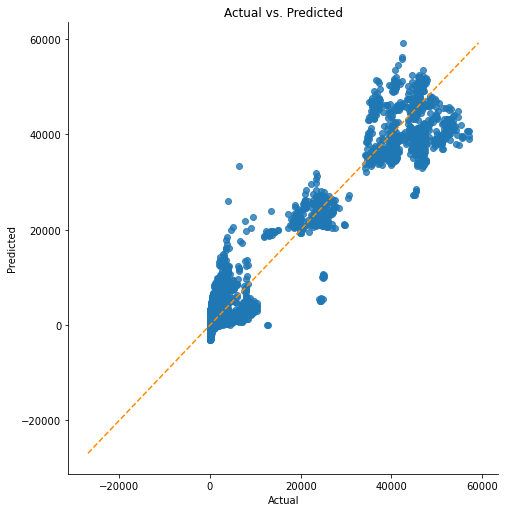

In [127]:

linear_assumption(reg, df[predictors],df[outcome])
# need to check non linear relationships with target

In [128]:
def normal_errors_assumption(model, features, label, p_value_thresh=0.05):
    """
    Normality: Assumes that the error terms are normally distributed. If they are not,
    nonlinear transformations of variables may solve this.
               
    This assumption being violated primarily causes issues with the confidence intervals
    """
    
    print('Assumption 2: The error terms are normally distributed', '\n')
    
    # Calculating residuals for the Anderson-Darling test
    df_results = calculate_residuals(model, features, label)
    
    print('Using the Anderson-Darling test for normal distribution')

    # Performing the test on the residuals
    p_value = normal_ad(df_results['Residuals'])[1]
    print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
    # Reporting the normality of the residuals
    if p_value < p_value_thresh:
        print('Residuals are not normally distributed')
    else:
        print('Residuals are normally distributed')
    
    # Plotting the residuals distribution
    plt.subplots(figsize=(12, 6))
    plt.title('Distribution of Residuals')
    sns.distplot(df_results['Residuals'])
    plt.show()
    
    print()
    if p_value > p_value_thresh:
        print('Assumption satisfied')
    else:
        print('Assumption not satisfied')
        print()
        print('Confidence intervals will likely be affected')
        print('Try performing nonlinear transformations on variables')

Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.0
Residuals are not normally distributed


C:\Users\Karamjyot\anaconda3\lib\site-packages\statsmodels\stats\_adnorm.py:70: RuntimeWarning: divide by zero encountered in log1p
  s = np.sum((2 * i[sl1] - 1.0) / nobs * (np.log(z) + np.log1p(-z[sl2])),
C:\Users\Karamjyot\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


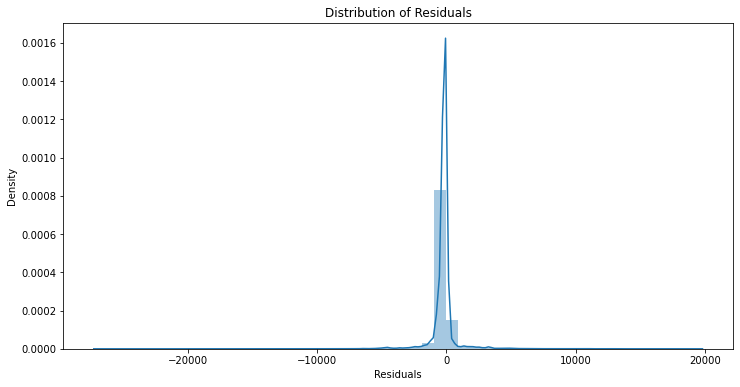


Assumption not satisfied

Confidence intervals will likely be affected
Try performing nonlinear transformations on variables


In [129]:
normal_errors_assumption(reg, df[predictors],df[outcome])
# loads of outliers is the reason need to do transformation 
# will try log-log regression

In [136]:
def multicollinearity_assumption(model, features, label, feature_names=None):
    """
    Multicollinearity: Assumes that predictors are not correlated with each other. If there is
                       correlation among the predictors, then either remove prepdictors with high
                       Variance Inflation Factor (VIF) values or perform dimensionality reduction
                           
                       This assumption being violated causes issues with interpretability of the 
                       coefficients and the standard errors of the coefficients.
    """
    
    print('Assumption 3: Little to no multicollinearity among predictors')
        
    # Plotting the heatmap
    #plt.figure(figsize = (10,8))
    #sns.heatmap(pd.DataFrame(features, columns=feature_names).corr(), annot=True)
    #plt.title('Correlation of Variables')
    #plt.show()
        
    print('Variance Inflation Factors (VIF)')
    print('> 10: An indication that multicollinearity may be present')
    print('> 100: Certain multicollinearity among the variables')
    print('-------------------------------------')
       
    # Gathering the VIF for each variable
    VIF = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
    for idx, vif in enumerate(VIF):
        print('{0}: {1}'.format(feature_names[idx], vif))
        
    # Gathering and printing total cases of possible or definite multicollinearity
    possible_multicollinearity = sum([1 for vif in VIF if vif > 10])
    definite_multicollinearity = sum([1 for vif in VIF if vif > 100])
    print()
    print('{0} cases of possible multicollinearity'.format(possible_multicollinearity))
    print('{0} cases of definite multicollinearity'.format(definite_multicollinearity))
    print()

    if definite_multicollinearity == 0:
        if possible_multicollinearity == 0:
            print('Assumption satisfied')
        else:
            print('Assumption possibly satisfied')
            print()
            print('Coefficient interpretability may be problematic')
            print('Consider removing variables with a high Variance Inflation Factor (VIF)')

    else:
        print('Assumption not satisfied')
        print()
        print('Coefficient interpretability will be problematic')
        print('Consider removing variables with a high Variance Inflation Factor (VIF)')

In [137]:
multicollinearity_assumption(reg,df[predictors],df[outcome],predictors)

Assumption 3: Little to no multicollinearity among predictors
Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
numbers_tested: 4.326945190742534
min_commit: 3.8466826210296428
has_min_commit: 2.4334662864975876
quality_too_poor: 1.2074780724891907
number_busy: 2.013613097950359
outage_sec: 1.417714006052655
temporarily_unable_test: 1.145179465006799
followup_tests: 1.7369822751218817
number_test_types_3: 2.3031740692425764
avg_pesq_score: 6.443213720687321
company_type_Conference: 1.2161461909771074
number_test_types_1: 5.790218712966577
number_test_types_2: 5.389774139885506
number_test_types_4: 1.8069597741063272
number_test_types_5: 1.161743378337224
is_testing_1: 8.162484377570095
Year_2020: 1.8066833229653467
Year_2021: 1.1709939482145038
Year_2019: 1.6019734186744272
number_test_types_6: 1.6663153164953302
Day_of_week_Monday: 1.2059787572957583
Mont

In [138]:
def autocorrelation_assumption(model, features, label):
    """
    Autocorrelation: Assumes that there is no autocorrelation in the residuals. If there is
                     autocorrelation, then there is a pattern that is not explained due to
                     the current value being dependent on the previous value.
                     This may be resolved by adding a lag variable of either the dependent
                     variable or some of the predictors.
    """
    
    print('Assumption 4: No Autocorrelation', '\n')
    
    # Calculating residuals for the Durbin Watson-tests
    df_results = calculate_residuals(model, features, label)

    print('\nPerforming Durbin-Watson Test')
    print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
    print('0 to 2< is positive autocorrelation')
    print('>2 to 4 is negative autocorrelation')
    print('-------------------------------------')
    durbinWatson = durbin_watson(df_results['Residuals'])
    print('Durbin-Watson:', durbinWatson)
    if durbinWatson < 1.5:
        print('Signs of positive autocorrelation', '\n')
        print('Assumption not satisfied')
    elif durbinWatson > 2.5:
        print('Signs of negative autocorrelation', '\n')
        print('Assumption not satisfied')
    else:
        print('Little to no autocorrelation', '\n')
        print('Assumption satisfied')

In [139]:
autocorrelation_assumption(reg,df[predictors],df[outcome])

Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 2.0318389170027085
Little to no autocorrelation 

Assumption satisfied


In [140]:
def homoscedasticity_assumption(model, features, label):
    """
    Homoscedasticity: Assumes that the errors exhibit constant variance
    """
    print('Assumption 5: Homoscedasticity of Error Terms', '\n')
    
    print('Residuals should have relative constant variance')
        
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)

    # Plotting the residuals
    plt.subplots(figsize=(12, 6))
    ax = plt.subplot(111)  # To remove spines
    plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
    plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
    ax.spines['right'].set_visible(False)  # Removing the right spine
    ax.spines['top'].set_visible(False)  # Removing the top spine
    plt.title('Residuals')
    plt.show()  

Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance


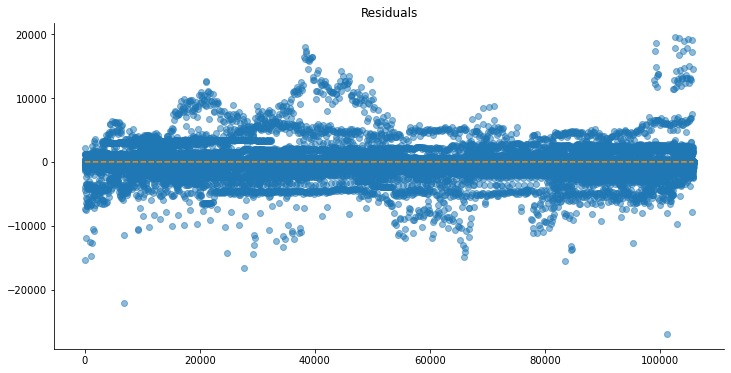

In [141]:
homoscedasticity_assumption(reg,df[predictors],df[outcome])

In [ ]:
# Looks like we need to run log-log regression to remove outliers and get
# Regression interpretations also 
# Before that we will try partial residual plots to check  non linear relation ship candidate ,
# we can even try to find the influence points but that would be better 
# after the final correct log model

In [28]:
# Taking above predictors we can check and verify significance level
predictors=['numbers_tested','min_commit','has_min_commit','quality_too_poor','number_busy','outage_sec','temporarily_unable_test',
'followup_tests','number_test_types_3','avg_pesq_score','company_type_Conference','number_test_types_1','number_test_types_2',
'number_test_types_4','number_test_types_5','is_testing_1','Year_2020','Year_2021','Year_2019','number_test_types_6','Day_of_week_Monday'
,'Month_4','Day_of_week_Sunday','Month_9','Month_8','Month_7','Day_of_week_Wednesday']
outcome = 'volume_tests'
model = sm.OLS(df[outcome], df[predictors].assign(const=1))
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:           volume_tests   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                 5.018e+04
Date:                Wed, 24 Nov 2021   Prob (F-statistic):               0.00
Time:                        15:22:57   Log-Likelihood:            -8.9300e+05
No. Observations:              105881   AIC:                         1.786e+06
Df Residuals:                  105853   BIC:                         1.786e+06
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
numbers_tested            

In [11]:
# checking influence 
influence = OLSInfluence(results)
sresiduals = influence.resid_studentized_internal

print(sresiduals.idxmin(), sresiduals.min())

101305 -27.25793352154338


In [19]:
print(results.resid.loc[sresiduals.idxmin()])
outlier = df.loc[sresiduals.idxmin(), :]
print('Volumetest', outlier[outcome])
print(outlier[predictors])
# the point which has the maximum influence on the regression
# has min commit of 75K and facing outage of around 3034 secs in 2021 while doing test type 2

-26926.323208998998
Volumetest 6422
numbers_tested                  667
min_commit                  75000.0
has_min_commit                    1
quality_too_poor                  0
number_busy                    3936
outage_sec                  3034.33
temporarily_unable_test           0
followup_tests                 3844
number_test_types_3               0
avg_pesq_score             3.890066
company_type_Conference           0
number_test_types_1               0
number_test_types_2               1
number_test_types_4               0
number_test_types_5               0
is_testing_1                      1
Year_2020                         0
Year_2021                         1
Year_2019                         0
number_test_types_6               0
Day_of_week_Monday                0
Month_4                           0
Day_of_week_Sunday                0
Month_9                           0
Month_8                           0
Month_7                           0
Day_of_week_Wednesday       

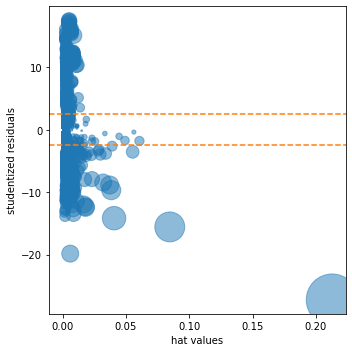

In [14]:
influence = OLSInfluence(results)
fig, ax = plt.subplots(figsize=(5, 5))
ax.axhline(-2.5, linestyle='--', color='C1')
ax.axhline(2.5, linestyle='--', color='C1')
ax.scatter(influence.hat_matrix_diag, influence.resid_studentized_internal, 
           s=1000 * np.sqrt(influence.cooks_distance[0]),
           alpha=0.5)

ax.set_xlabel('hat values')
ax.set_ylabel('studentized residuals')

plt.tight_layout()
plt.show()

In [15]:
mask = [dist < .08 for dist in influence.cooks_distance[0]]
house_infl = df.loc[mask]

ols_infl = sm.OLS(df[outcome], df[predictors].assign(const=1))
result_infl = ols_infl.fit()

pd.DataFrame({
    'Original': results.params,
    'Influential removed': result_infl.params,
})

# we can see we dont have any change it means , there are almost no points which are potentially 
# skewing the regression 

,Original,Influential removed
numbers_tested,6.474778,6.474778
min_commit,0.042534,0.042534
has_min_commit,-502.768219,-502.768219
quality_too_poor,23.007681,23.007681
number_busy,3.011169,3.011169
outage_sec,-0.095883,-0.095883
temporarily_unable_test,6.500530,6.500530
followup_tests,3.806375,3.806375
number_test_types_3,-135.336895,-135.336895
avg_pesq_score,138.878174,138.878174


In [ ]:
#y_pred = model.predict(df[predictors])
#df['volume_tests']-ypred

In [17]:
#fig, ax = plt.subplots(figsize=(5, 5))
#sns.regplot(x=results.fittedvalues, y=np.abs(results.resid), 
#            scatter_kws={'alpha': 0.25},
#            line_kws={'color': 'C1'},
#            lowess=True, ax=ax)
#ax.set_xlabel('predicted')
#ax.set_ylabel('abs(residual)')

#plt.tight_layout()
#plt.show()

# Partial Regression plot

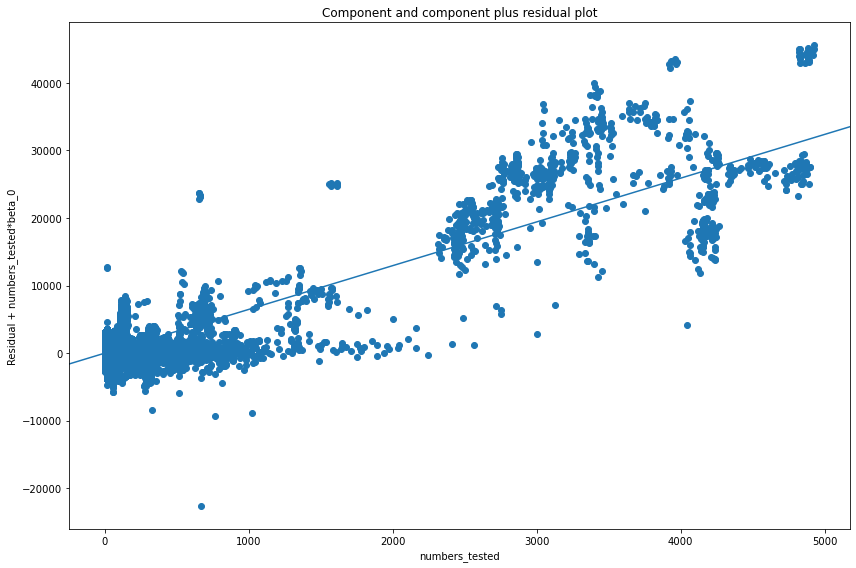

In [146]:
# check relation between outcome and numbers_tested 
fig, ax = plt.subplots(figsize=(12, 8))
fig = sm.graphics.plot_ccpr(results, 'numbers_tested', ax=ax)

plt.tight_layout()
plt.show()
# clearly its not linear

In [38]:

#def partialResidualPlot(model, df, outcome, feature, ax):
#    y_pred = model.predict(df)
#    copy_df = df.copy()
#    for c in copy_df.columns:
#        if c == feature:
#            continue
#        copy_df[c] = 0.0
#    feature_prediction = model.predict(copy_df)
#    results = pd.DataFrame({
#        'feature': df[feature],
#        'residual': outcome - y_pred,
#        'ypartial': feature_prediction - model.params[0],
#    })
#    results = results.sort_values(by=['feature'])
#    smoothed = sm.nonparametric.lowess(results.ypartial, results.feature, frac=1/3)
    
#    ax.scatter(results.feature, results.ypartial + results.residual)
#    ax.plot(smoothed[:, 0], smoothed[:, 1], color='gray')
#    ax.plot(results.feature, results.ypartial, color='black')
#    ax.set_xlabel(feature)
#    ax.set_ylabel(f'Residual + {feature} contribution')
#    return ax

#fig, ax = plt.subplots(figsize=(5, 5))
#dfbase=df[predictors].copy()
#dfbase = sm.add_constant(dfbase)
#partialResidualPlot(results, dfbase,df['volume_tests'], 'numbers_tested', ax)

#plt.tight_layout()
#plt.show()
#print(results.params[2])

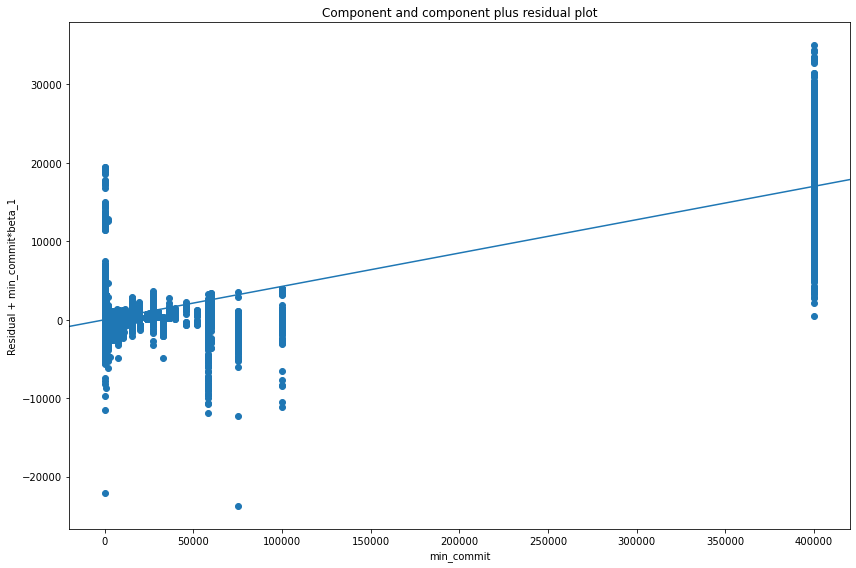

In [147]:
# check with other numeric columns
#'min_commit','quality_too_poor','number_busy','outage_sec','temporarily_unable_test',
# 'followup_tests','avg_pesq_score'
fig, ax = plt.subplots(figsize=(12, 8))
fig = sm.graphics.plot_ccpr(results, 'min_commit', ax=ax)

plt.tight_layout()
plt.show()
# not linear 

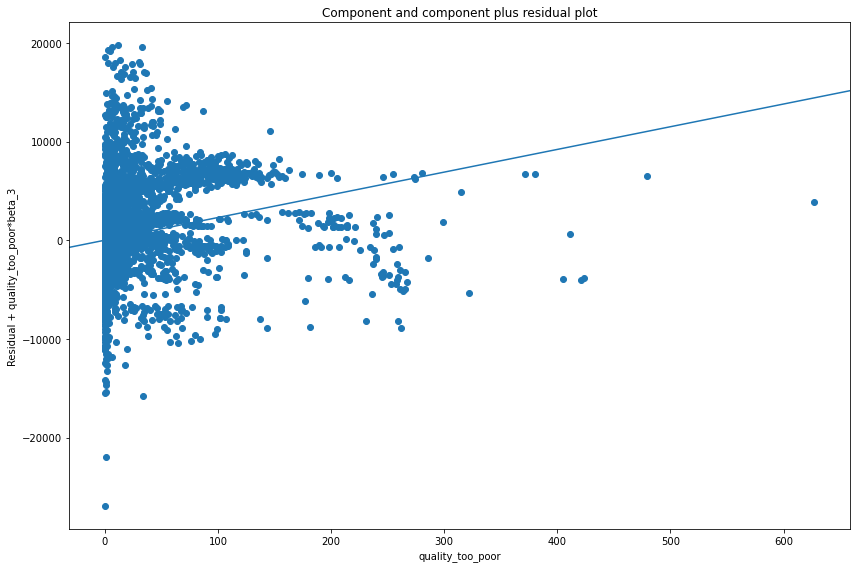

In [148]:
fig, ax = plt.subplots(figsize=(12, 8))
fig = sm.graphics.plot_ccpr(results, 'quality_too_poor', ax=ax)

plt.tight_layout()
plt.show()
# high variance and not linear we need transformation of variables

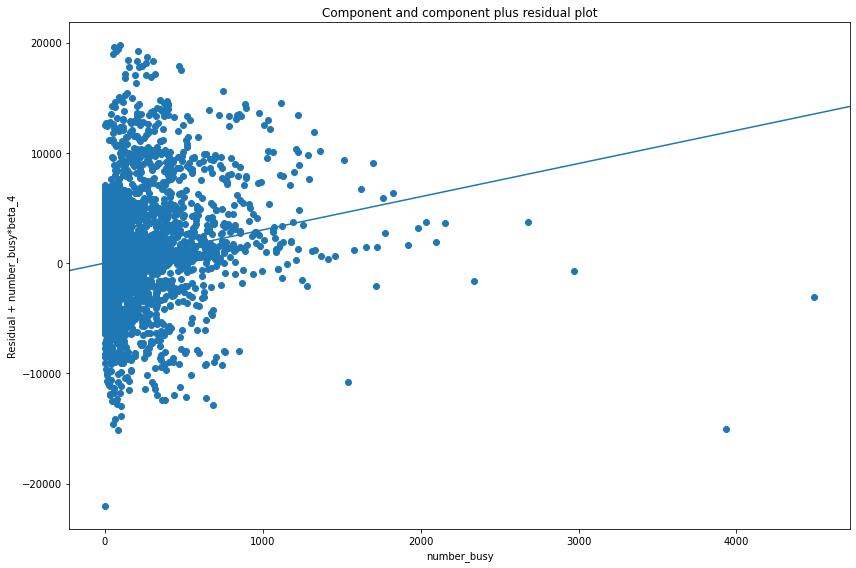

In [149]:
fig, ax = plt.subplots(figsize=(12, 8))
fig = sm.graphics.plot_ccpr(results, 'number_busy', ax=ax)

plt.tight_layout()
plt.show()
# we see same pattern we will try log log regression now

# LOG LOG Regression 

In [159]:
log_df=df.copy()
scaler = StandardScaler()
a=log_df['avg_pesq_score']
b=log_df['quality_too_poor']
c=log_df['number_busy']
d=log_df['temporarily_unable_test']
e=log_df['outage_sec']
f=log_df['numbers_tested']
g=log_df['followup_tests']
h=log_df['min_commit']
o=log_df['volume_tests']

log_df['avg_pesq_score']=scaler.fit_transform(a.values.reshape(-1,1))
log_df['quality_too_poor']=scaler.fit_transform(b.values.reshape(-1,1))
log_df['number_busy']=scaler.fit_transform(c.values.reshape(-1,1))
log_df['temporarily_unable_test']=scaler.fit_transform(d.values.reshape(-1,1))
log_df['outage_sec']=scaler.fit_transform(e.values.reshape(-1,1))
log_df['numbers_tested']=scaler.fit_transform(f.values.reshape(-1,1))
log_df['followup_tests']=scaler.fit_transform(g.values.reshape(-1,1))
log_df['min_commit']=scaler.fit_transform(h.values.reshape(-1,1))
log_df['volume_tests']=scaler.fit_transform(o.values.reshape(-1,1))

log_df['avg_pesq_score']=np.log1p(a)
log_df['quality_too_poor']=np.log1p(b)
log_df['number_busy']=np.log1p(c)
log_df['temporarily_unable_test']=np.log1p(d)
log_df['outage_sec']=np.log1p(e)
log_df['numbers_tested']=np.log1p(f)
log_df['followup_tests']=np.log1p(g)
log_df['min_commit']=np.log1p(h)
log_df['volume_tests']=np.log1p(o)

predictors=['numbers_tested','min_commit','has_min_commit','quality_too_poor','number_busy','outage_sec',
'temporarily_unable_test','followup_tests','number_test_types_3','avg_pesq_score',
'company_type_Conference','number_test_types_1','number_test_types_2','number_test_types_4',
'number_test_types_5','is_testing_1','Year_2020','Year_2021','Year_2019','number_test_types_6',
'Day_of_week_Monday','Month_4','Day_of_week_Sunday','Month_9','Month_8','Month_7',
'Day_of_week_Wednesday']
outcome='volume_tests'

model = sm.OLS(log_df[outcome], log_df[predictors].assign(const=1))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           volume_tests   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                 3.956e+04
Date:                Sat, 20 Nov 2021   Prob (F-statistic):               0.00
Time:                        12:00:42   Log-Likelihood:            -1.3124e+05
No. Observations:              105881   AIC:                         2.625e+05
Df Residuals:                  105853   BIC:                         2.628e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
numbers_tested            

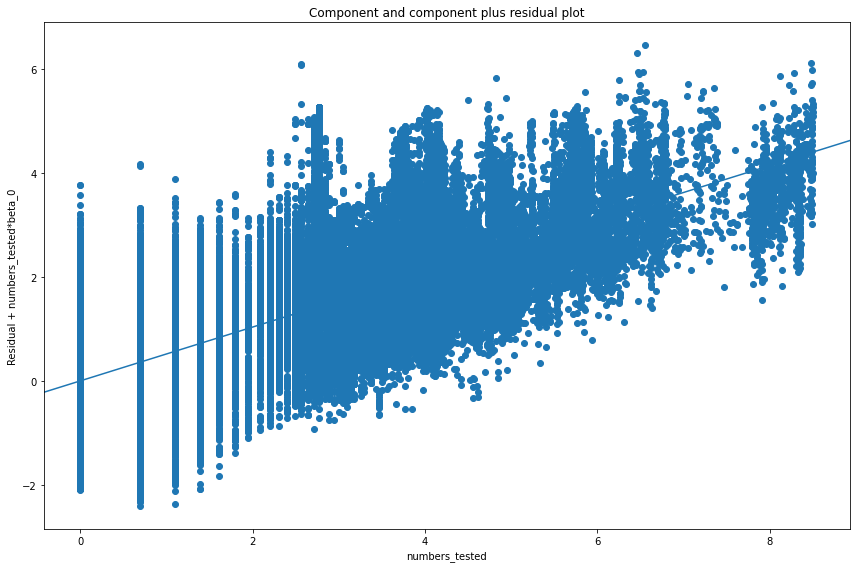

In [160]:
fig, ax = plt.subplots(figsize=(12, 8))
fig = sm.graphics.plot_ccpr(results, 'numbers_tested', ax=ax)

plt.tight_layout()
plt.show()
# transformation is not that good but relationship is turned almost linear

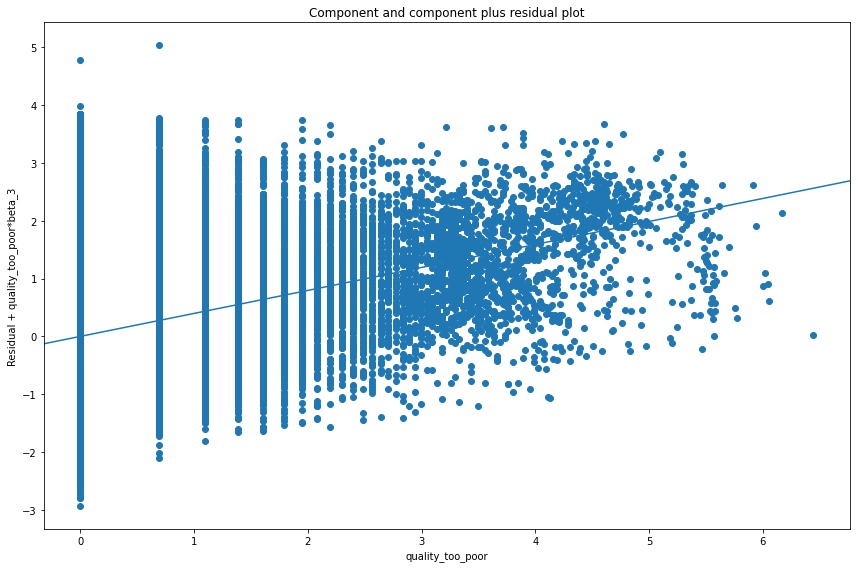

In [161]:
fig, ax = plt.subplots(figsize=(12, 8))
fig = sm.graphics.plot_ccpr(results, 'quality_too_poor', ax=ax)

plt.tight_layout()
plt.show()
# high variance at begining we need to try some other kind of transformation

In [163]:
# will check other assumtions are correct or not
reg = LinearRegression()
reg.fit(log_df[predictors], log_df[outcome])

print(f'Intercept: {reg.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(predictors, reg.coef_):
    print(f' {name}: {coef}')
fitted = reg.predict(log_df[predictors])
RMSE = np.sqrt(mean_squared_error(log_df[outcome], fitted))
r2 = r2_score(log_df[outcome], fitted)
print(f'RMSE: {RMSE:.0f}')
print(f'r2: {r2:.4f}')

Intercept: 0.208
Coefficients:
 numbers_tested: 0.517655367866373
 min_commit: 0.1962744321975639
 has_min_commit: -1.607202644185531
 quality_too_poor: 0.3974536425772944
 number_busy: 0.3142256673229048
 outage_sec: -0.028928777964666585
 temporarily_unable_test: 0.13841323275687512
 followup_tests: 0.019752926311157236
 number_test_types_3: 0.0932438633349312
 avg_pesq_score: 0.364059565981137
 company_type_Conference: -0.12578344357402102
 number_test_types_1: -0.08745774082640644
 number_test_types_2: 0.06461737005958415
 number_test_types_4: 0.0984885809572927
 number_test_types_5: 0.29561011053091646
 is_testing_1: 2.3228262133355466
 Year_2020: -0.09719114705360596
 Year_2021: -0.10760126303862846
 Year_2019: -0.05922672491315206
 number_test_types_6: 0.20372537941368898
 Day_of_week_Monday: 0.009709484770106542
 Month_4: 0.031033611909670713
 Day_of_week_Sunday: -0.10113971902129838
 Month_9: 0.016609829621148542
 Month_8: 0.0016284250976092165
 Month_7: 0.0122477340567125
 Da

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


C:\Users\Karamjyot\anaconda3\lib\site-packages\seaborn\regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


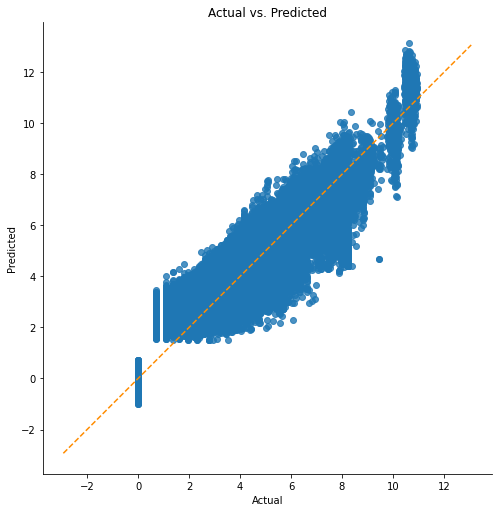

In [165]:
linear_assumption(reg, log_df[predictors],log_df[outcome])
# we need non linear trasnsformation 


Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.0
Residuals are not normally distributed


C:\Users\Karamjyot\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


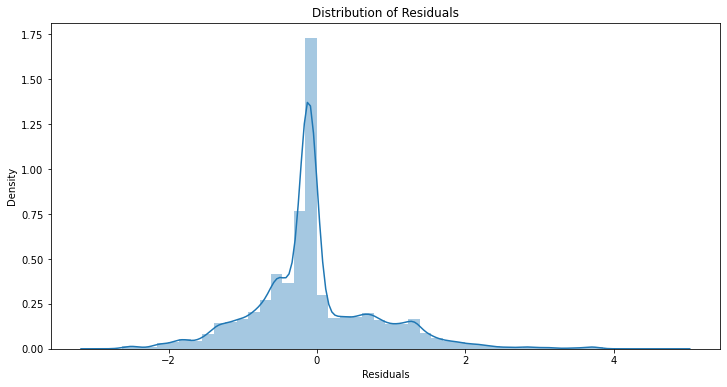


Assumption not satisfied

Confidence intervals will likely be affected
Try performing nonlinear transformations on variables


In [166]:
normal_errors_assumption(reg, log_df[predictors],log_df[outcome])
# skewed towards negative values

Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance


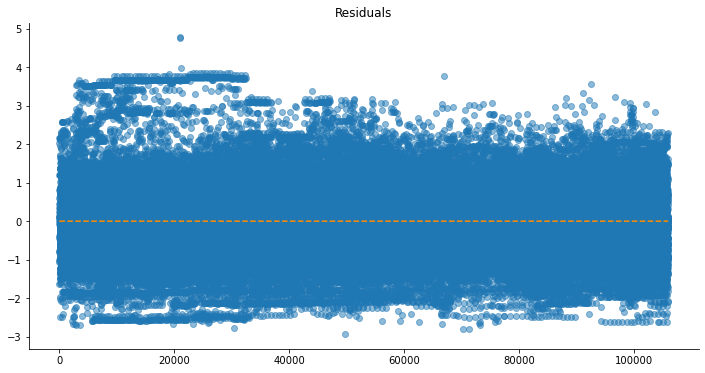

In [167]:
homoscedasticity_assumption(reg,log_df[predictors],log_df[outcome])
# the multicolinearity , homoscedasticity and autocorelation are not the problem
# problem is outliers and non linear relationships , better than base model but we will try 
# yea-johnson transformed variables and then check the model
# then we will try 

# yea-johnson transformed variable Regression

In [170]:
num_cols=['avg_pesq_score','quality_too_poor','number_busy','temporarily_unable_test',
          'outage_sec','numbers_tested','followup_tests','min_commit','volume_tests']

yj = PowerTransformer(method="yeo-johnson")
df_yea_jhon=df.copy()
df_yea_jhon[num_cols] = yj.fit(df_yea_jhon[num_cols]).transform(df_yea_jhon[num_cols])

In [171]:
model = sm.OLS(df_yea_jhon[outcome], df_yea_jhon[predictors].assign(const=1))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           volume_tests   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                 4.323e+04
Date:                Sat, 20 Nov 2021   Prob (F-statistic):               0.00
Time:                        12:23:46   Log-Likelihood:                -18566.
No. Observations:              105881   AIC:                         3.719e+04
Df Residuals:                  105853   BIC:                         3.746e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
numbers_tested            

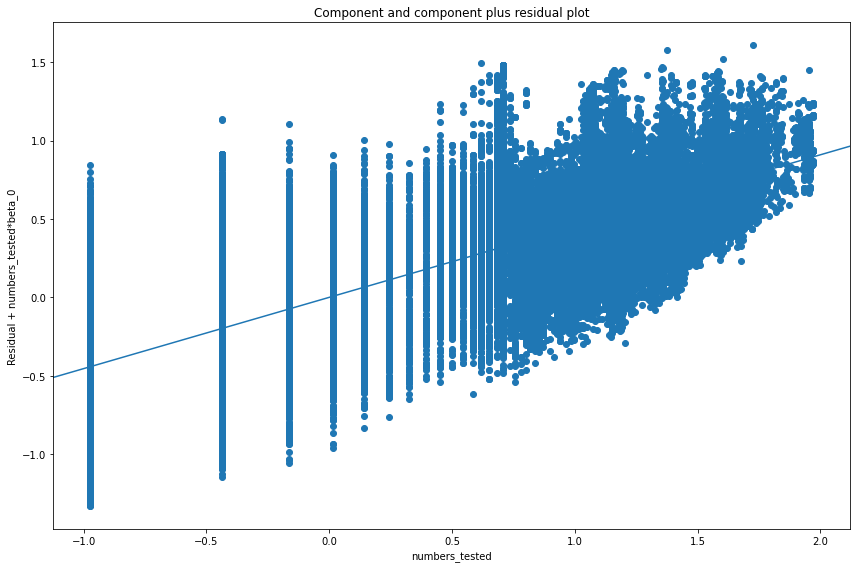

In [172]:
fig, ax = plt.subplots(figsize=(12, 8))
fig = sm.graphics.plot_ccpr(results, 'numbers_tested', ax=ax)

plt.tight_layout()
plt.show()

Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.0
Residuals are not normally distributed


C:\Users\Karamjyot\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


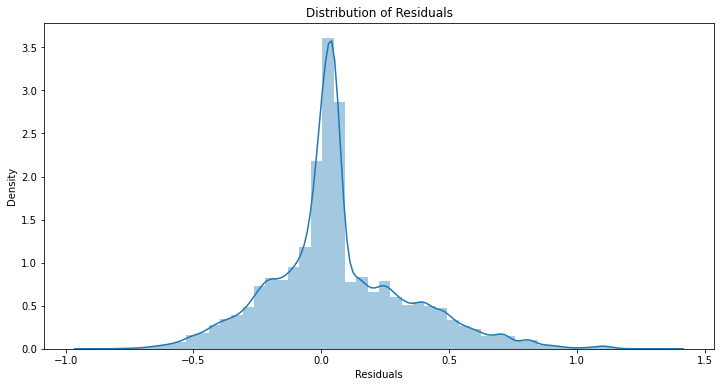


Assumption not satisfied

Confidence intervals will likely be affected
Try performing nonlinear transformations on variables


In [174]:
reg = LinearRegression()
reg.fit(df_yea_jhon[predictors], df_yea_jhon[outcome])
normal_errors_assumption(reg, df_yea_jhon[predictors],df_yea_jhon[outcome])


# polynomial regression

In [ ]:
# not helped that mich we will try poly fit and splines and or else
# generalized additive model at the end


In [179]:
# polynomial 
poly = PolynomialFeatures(degree = 2)
X_poly = poly.fit_transform(df[predictors])
lin2 = LinearRegression()
lin2.fit(X_poly, df[outcome])

print(f'Intercept: {lin2.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(predictors, lin2.coef_):
    print(f' {name}: {coef}')
fitted = lin2.predict(X_poly)
RMSE = np.sqrt(mean_squared_error(df[outcome], fitted))
r2 = r2_score(df[outcome], fitted)
print(f'RMSE: {RMSE:.0f}')
print(f'r2: {r2:.4f}')

Intercept: 43.473
Coefficients:
 numbers_tested: 0.46505480090080226
 min_commit: 3.39486595437291
 has_min_commit: -0.005623252695840285
 quality_too_poor: -50.076093257157936
 number_busy: 6.478226070732456
 outage_sec: 0.6459598756895276
 temporarily_unable_test: -0.04776850752588944
 followup_tests: 4.318429845332479
 number_test_types_3: 7.113114752397581
 avg_pesq_score: 222.83078939692368
 company_type_Conference: -526.4338511780693
 number_test_types_1: 60.65563895050348
 number_test_types_2: -110.42734374356588
 number_test_types_4: 33.8420610241918
 number_test_types_5: 796.6352506828771
 is_testing_1: 2953.4995410870347
 Year_2020: 38.24337817824612
 Year_2021: -38.251445563405234
 Year_2019: -44.88349710685032
 number_test_types_6: -25.107422980875434
 Day_of_week_Monday: 8661.955951951291
 Month_4: -17.70007358008233
 Day_of_week_Sunday: -0.8934188740642167
 Month_9: 27.642726050736034
 Month_8: -17.402159426051043
 Month_7: 4.384243700517237
 Day_of_week_Wednesday: -2.897

In [183]:
model = sm.OLS(df[outcome], X_poly)
results = model.fit()
print(results.summary())
# overfit like anything 

                            OLS Regression Results                            
Dep. Variable:           volume_tests   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                 1.893e+04
Date:                Sat, 20 Nov 2021   Prob (F-statistic):               0.00
Time:                        12:39:02   Log-Likelihood:            -8.1410e+05
No. Observations:              105881   AIC:                         1.629e+06
Df Residuals:                  105544   BIC:                         1.632e+06
Df Model:                         336                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         43.9395      8.385      5.241      0.0

In [187]:
# we can try using formula in ols and do polynomial regression like that
# we can do crossvalidation loop but it will be to much coding as of now we will just add few 
# polynomial and interaction terms
# here comes the business understanding we can try and test interactions
# or we can run a gridsearch for all interactions which will be complex and time consuming
# # we can even try log -log with polynomial which might be the best solution
model_poly = smf.ols(formula='volume_tests ~  numbers_tested + np.power(numbers_tested, 2) + ' + 
                     'avg_pesq_score  +  quality_too_poor + number_busy + temporarily_unable_test +'+
                     'outage_sec + followup_tests + min_commit + np.power(min_commit, 2)+ ' +
                     ' number_test_types_3 + company_type_Conference+ company_type_Conference:followup_tests +'+
                     'number_test_types_1 + Day_of_week_Sunday:followup_tests + ' +
                     'number_test_types_2  + number_test_types_5 +'+
                     'Year_2020  + Year_2019 + number_test_types_6+ Day_of_week_Monday +'+
                     'Month_4 + Day_of_week_Sunday + Month_9 + Month_8 + Month_7  ', data=df)

result_poly = model_poly.fit()
print(result_poly.summary())
# we are removing is_testing which was a strong corelation between volume test
# we added polynomial function of numbers testing and is_testing became insignificant
# this means there is a confounding variable missing 
# is_testing and numbers_tested are related to each other by some other feature which is missing
# we had to remove year 2021 as it became insignificant , might be we have started over fitting
# data towards 2021 before , this might be a problem as we are going to use model for future
# polynomials addition to that have very bad prediction rate at the ends ( bad at extrapolation)
# this strengths the argument for splines and glm

                            OLS Regression Results                            
Dep. Variable:           volume_tests   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                 7.284e+04
Date:                Sat, 20 Nov 2021   Prob (F-statistic):               0.00
Time:                        13:08:13   Log-Likelihood:            -8.7638e+05
No. Observations:              105881   AIC:                         1.753e+06
Df Residuals:                  105854   BIC:                         1.753e+06
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

# Splines Regression 

In [ ]:
# one thing which we have not taken care is the drop in test volume we had
# changepoint effect we can try splines regression to try address that

In [ ]:
# we can try splines instead of power 2 transform we know we have at most 2 change points
# we can have 3 knots  
# more advance we can try both generalized linear models with splines , poisson transformation with 
# b-splines but as it will require more time

In [189]:
formula = ('volume_tests ~ bs(numbers_tested, df=6, degree=3) + bs(avg_pesq_score, df=6, degree=3)+ ' + 
           ' bs(avg_pesq_score, df=6, degree=3)  + bs(quality_too_poor, df=6, degree=3)  + '+
           ' bs(number_busy, df=6, degree=3)  + bs(temporarily_unable_test, df=6, degree=3)  +'+
           'outage_sec + bs(followup_tests, df=6, degree=3)  + bs(min_commit, df=6, degree=3) + ' +
           ' number_test_types_3 + company_type_Conference+ company_type_Conference:followup_tests +'+
           'number_test_types_1 +  ' +
           'number_test_types_2  + number_test_types_5 +'+
           'Year_2020  + Year_2019 + number_test_types_6+ Day_of_week_Monday +'+
           'Month_4 + Day_of_week_Sunday + Month_9 + Month_8 + Month_7  ')
model_spline = smf.ols(formula=formula, data=df)
result_spline = model_spline.fit()
print(result_spline.summary())
# after adding follow up test splines its interaction effect  with sunday has become insignificant
# we will remove the interaction effect

                            OLS Regression Results                            
Dep. Variable:           volume_tests   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                 6.295e+04
Date:                Sat, 20 Nov 2021   Prob (F-statistic):               0.00
Time:                        13:29:19   Log-Likelihood:            -8.5951e+05
No. Observations:              105881   AIC:                         1.719e+06
Df Residuals:                  105838   BIC:                         1.720e+06
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

In [ ]:
 # we have a very goo adjusted r2 score of 96 this might not be a over fit we can try
# and test it on saved data later after trying non-linear models
# other methods are also there local linear regression

In [ ]:
# lets tranform out orignial train dataset

num_cols=['avg_pesq_score','quality_too_poor','number_busy','temporarily_unable_test','outage_sec','numbers_tested','followup_tests','min_commit']
yj = PowerTransformer(method="yeo-johnson")
df[num_cols] = yj.fit(numeric_data).transform(df[num_cols])